In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
import os
import ipywidgets as widgets
from IPython.display import display
import datetime

___
#### Data binnenhalen
___

In [4]:
locs = {'waiting_folder' : '../data/waiting times'}

waiting_times = list()
for attraction in tqdm(os.listdir(locs['waiting_folder'])):
    filename = os.path.join(locs['waiting_folder'], attraction)
    df = pd.read_csv(filename)
    if df.empty:
        continue
    df.insert(0, 'attraction', attraction.split('.')[0])
    waiting_times.append(df)

df_wait_raw = pd.concat(waiting_times, ignore_index=True)

  0%|          | 0/52 [00:00<?, ?it/s]

100%|██████████| 52/52 [00:08<00:00,  6.38it/s]


In [5]:
df_wait = df_wait_raw.copy()
# Cleaning the actual waiting times
# Removing outliers from actuals
df_wait = df_wait[((df_wait.SACTMIN >= -1000) & (df_wait.SACTMIN < 360)) | (df_wait.SACTMIN.isnull())]
# Removing outliers from posted (attraction closed at -999)
df_wait = df_wait[(df_wait.SPOSTMIN >= -998.99) | (df_wait.SPOSTMIN.isnull())]

df_wait['date'] = pd.to_datetime(df_wait.date, format = '%m/%d/%Y')
df_wait['datetime'] = pd.to_datetime(df_wait.datetime, format = '%Y-%m-%d %H:%M:%S')

print(f"Removed {len(df_wait_raw) - len(df_wait)} rows")

# You could split the dataset into two seperate dataframes (plusjes & minnetjes :-))
df_wait_act = df_wait[~df_wait.SACTMIN.isnull()].drop('SPOSTMIN', axis = 1)
df_wait_post = df_wait[~df_wait.SPOSTMIN.isnull()].drop('SACTMIN', axis = 1)

attractions = df_wait.attraction.unique()

# Extract "minutes from df_wait" from the datetime column
df_wait_post['minute'] = df_wait_post['datetime'].dt.hour * 60 + df_wait_post['datetime'].dt.minute

df_wait_post['attraction'].unique()

Removed 1295640 rows


array(['alien_saucers', 'astro_orbiter', 'barnstormer', 'big_thunder_mtn',
       'buzz_lightyear', 'carousel_of_progress', 'country_bears',
       'dinosaur', 'dumbo', 'enchanted_tiki_rm', 'expedition_everest',
       'flight_of_passage', 'hall_of_presidents', 'haunted_mansion',
       'it_s_a_small_world', 'jungle_cruise', 'kilimanjaro_safaris',
       'laugh_floor', 'liberty_sq_riverboat', 'mad_tea_party',
       'magic_carpets', 'navi_river', 'peoplemover', 'peter_pan_s_flight',
       'philharmagic', 'pirates_of_caribbean', 'pirate_s_adventure',
       'princess_hall__cinderella_elena', 'princess_hall__rapunzel_tiana',
       'regal_carrousel', 'rock_n_rollercoaster', 'slinky_dog', 'soarin',
       'sorcerers_of_the_mk', 'spaceship_earth', 'space_mountain',
       'splash_mountain', 'swiss_family_tree', 'tom_land_speedway',
       'tom_sawyer_island', 'town_sq_mickey', 'toy_story_mania',
       'under_the_sea', 'winnie_the_pooh'], dtype=object)

In [6]:
df_int_time_p = pd.read_csv("../data/clean/posted_interpolated.csv")
display(df_int_time_p.head())

,attraction,date,minute,SPOSTMIN
0,astro_orbiter,2015-01-01,0,0.0
1,astro_orbiter,2015-01-01,30,0.0
2,astro_orbiter,2015-01-01,60,0.0
3,astro_orbiter,2015-01-01,90,0.0
4,astro_orbiter,2015-01-01,120,0.0


In [7]:
df_act_shifted = pd.read_csv("../data/clean/actuals_shifted.csv")
display(df_act_shifted.head())

,attraction,date,datetime,SACTMIN,minute
0,barnstormer,2015-01-01,2015-01-01 10:39:48,18.0,639
1,big_thunder_mtn,2015-01-01,2015-01-01 14:55:16,37.0,895
2,buzz_lightyear,2015-01-01,2015-01-01 10:24:25,69.0,624
3,buzz_lightyear,2015-01-01,2015-01-01 14:36:06,62.0,876
4,country_bears,2015-01-01,2015-01-01 10:12:43,0.0,612


In [8]:
df_training_data = pd.read_csv("../data/clean/training_dataset.csv")
display(df_training_data.head())

,attraction,date,actual_over_posted
0,barnstormer,2015-01-01,0.900000
1,big_thunder_mtn,2015-01-01,0.528571
2,buzz_lightyear,2015-01-01,1.061538
3,buzz_lightyear,2015-01-01,1.078261
4,dumbo,2015-01-01,0.200000


In [9]:
df_wt_pred = pd.read_csv("../data/clean/waiting_times_with_prediction.csv", index_col=0)
display(df_wt_pred.head())

,attraction,date,minute,SPOSTMIN,SACTMIN,predicted_actual_time
0,astro_orbiter,2015-01-01,0,0.0,NaN,0.0
1,astro_orbiter,2015-01-01,30,0.0,NaN,0.0
2,astro_orbiter,2015-01-01,60,0.0,NaN,0.0
3,astro_orbiter,2015-01-01,90,0.0,NaN,0.0
4,astro_orbiter,2015-01-01,120,0.0,NaN,0.0


In [10]:
df_entities_extra_raw = pd.read_csv(('../data/overview data/entities_extra.csv'))
display(df_entities_extra_raw.head())

,name,fastpass_booth,created_at,updated_at,short_name,open_emh_morning,open_emh_evening,single_rider,time_zone,seasonal,...,masthead_circle_y,latitude,longitude,open_early,themeparks_id,has_virtual_queue,relative_open_base,virtual_queue_only,fastpass_average_minutes_saved,fastpass_average_gone_at
0,Astro Orbiter,False,2009-07-13T19:14:03.000-04:00,2021-11-15T12:59:25.000-05:00,Astro Orbiter,True,True,False,Eastern Time (US & Canada),False,...,31,28.418493,-81.578989,False,d9d12438-d999-4482-894b-8955fdb20ccf,False,0,False,0,0
1,The Barnstormer,False,2009-07-13T19:14:05.000-04:00,2023-01-15T22:03:41.000-05:00,Barnstormer,True,True,False,Eastern Time (US & Canada),False,...,157,28.420766,-81.578391,False,924a3b2c-6b4b-49e5-99d3-e9dc3f2e8a48,False,0,False,3,2000-01-01T21:00:00.000Z
2,Bibbidi Bobbidi Boutique,False,2019-11-27T06:45:19.000-05:00,2020-08-18T12:14:30.000-04:00,Bibbidi Bobbidi Boutique,False,False,False,Eastern Time (US & Canada),False,...,0,28.419479,-81.581235,False,0,False,0,False,0,0
3,Big Thunder Mountain Railroad,False,2009-07-13T16:14:03.000-07:00,2023-03-21T10:41:21.000-07:00,Big Thunder Mtn,False,True,False,Eastern Time (US & Canada),False,...,194,28.419964,-81.584642,False,de3309ca-97d5-4211-bffe-739fed47e92f,False,0,False,19,2000-01-01T18:00:00.000Z
4,Buzz Lightyear's Space Ranger Spin,False,2009-07-13T16:14:03.000-07:00,2023-03-21T09:15:14.000-07:00,Buzz Lightyear,True,True,False,Eastern Time (US & Canada),False,...,80,28.418287,-81.579409,False,72c7343a-f7fb-4f66-95df-c91016de7338,False,0,False,23,2000-01-01T21:00:00.000Z


In [11]:
entities_raw = pd.read_csv('../data/overview data/entities.csv')
display(entities_raw.head())

,code,name,short_name,land,opened_on,duration,average_wait_per_hundred
0,AK01,It's Tough to Be a Bug!,It's Tough to Be a Bug,Discovery Island,04/22/1998,8.0,12.0
1,AK07,Kilimanjaro Safaris,Kilimanjaro Safaris,Africa,04/22/1998,20.0,4.0
2,AK11,Expedition Everest - Legend of the Forbidden M...,Expedition Everest,Asia,04/07/2006,4.0,4.0
3,AK14,Kali River Rapids,Kali River Rapids,Asia,02/15/1999,10.0,5.0
4,AK18,DINOSAUR,DINOSAUR,DinoLand U.S.A.,04/22/1998,3.5,3.0


In [12]:
df_metadata_raw = pd.read_csv(('../data/overview data/metadata.csv'))
display(df_metadata_raw.head())

,DATE,WDW_TICKET_SEASON,DAYOFWEEK,DAYOFYEAR,WEEKOFYEAR,MONTHOFYEAR,YEAR,SEASON,HOLIDAYPX,HOLIDAYM,...,HSFIREWKS,AKPRDDAY,AKPRDDT1,AKPRDDT2,AKPRDDN,AKFIREN,AKSHWNGT,AKSHWNT1,AKSHWNT2,AKSHWNN
0,01/01/2015,NaN,5,0,0,1,2015,CHRISTMAS PEAK,0,5,...,1,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
1,01/02/2015,NaN,6,1,0,1,2015,CHRISTMAS,2,5,...,1,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
2,01/03/2015,NaN,7,2,0,1,2015,CHRISTMAS,3,0,...,1,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
3,01/04/2015,NaN,1,3,1,1,2015,CHRISTMAS,4,0,...,1,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
4,01/05/2015,NaN,2,4,1,1,2015,CHRISTMAS,5,0,...,1,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN


___
#### Datacleaning
- dropping columns
- changing types
- making smaller dataframes (categorically)
- merging
___

In [13]:
# merge_name komt overeen met de naam uit de waiting_time data
df_entities_extra_all = df_entities_extra_raw.copy()

df_entities_extra_all['merge_name'] = df_entities_extra_all['short_name'].copy().str.lower().str.replace(r"[\s':/]", "_", regex=True)
display(df_entities_extra_all.head())

,name,fastpass_booth,created_at,updated_at,short_name,open_emh_morning,open_emh_evening,single_rider,time_zone,seasonal,...,latitude,longitude,open_early,themeparks_id,has_virtual_queue,relative_open_base,virtual_queue_only,fastpass_average_minutes_saved,fastpass_average_gone_at,merge_name
0,Astro Orbiter,False,2009-07-13T19:14:03.000-04:00,2021-11-15T12:59:25.000-05:00,Astro Orbiter,True,True,False,Eastern Time (US & Canada),False,...,28.418493,-81.578989,False,d9d12438-d999-4482-894b-8955fdb20ccf,False,0,False,0,0,astro_orbiter
1,The Barnstormer,False,2009-07-13T19:14:05.000-04:00,2023-01-15T22:03:41.000-05:00,Barnstormer,True,True,False,Eastern Time (US & Canada),False,...,28.420766,-81.578391,False,924a3b2c-6b4b-49e5-99d3-e9dc3f2e8a48,False,0,False,3,2000-01-01T21:00:00.000Z,barnstormer
2,Bibbidi Bobbidi Boutique,False,2019-11-27T06:45:19.000-05:00,2020-08-18T12:14:30.000-04:00,Bibbidi Bobbidi Boutique,False,False,False,Eastern Time (US & Canada),False,...,28.419479,-81.581235,False,0,False,0,False,0,0,bibbidi_bobbidi_boutique
3,Big Thunder Mountain Railroad,False,2009-07-13T16:14:03.000-07:00,2023-03-21T10:41:21.000-07:00,Big Thunder Mtn,False,True,False,Eastern Time (US & Canada),False,...,28.419964,-81.584642,False,de3309ca-97d5-4211-bffe-739fed47e92f,False,0,False,19,2000-01-01T18:00:00.000Z,big_thunder_mtn
4,Buzz Lightyear's Space Ranger Spin,False,2009-07-13T16:14:03.000-07:00,2023-03-21T09:15:14.000-07:00,Buzz Lightyear,True,True,False,Eastern Time (US & Canada),False,...,28.418287,-81.579409,False,72c7343a-f7fb-4f66-95df-c91016de7338,False,0,False,23,2000-01-01T21:00:00.000Z,buzz_lightyear


In [14]:
# extra entities for all the attractions we have waiting times for

attractions_with_waitingtimes = df_wait['attraction'].unique()
df_att_with_waittime = pd.DataFrame(attractions_with_waitingtimes, columns=['attraction'])

valid_attractions = set(df_att_with_waittime['attraction'])
df_entities_extra_valid = df_entities_extra_all[df_entities_extra_all['merge_name'].isin(valid_attractions)]
display(df_entities_extra_valid.head())

,name,fastpass_booth,created_at,updated_at,short_name,open_emh_morning,open_emh_evening,single_rider,time_zone,seasonal,...,latitude,longitude,open_early,themeparks_id,has_virtual_queue,relative_open_base,virtual_queue_only,fastpass_average_minutes_saved,fastpass_average_gone_at,merge_name
0,Astro Orbiter,False,2009-07-13T19:14:03.000-04:00,2021-11-15T12:59:25.000-05:00,Astro Orbiter,True,True,False,Eastern Time (US & Canada),False,...,28.418493,-81.578989,False,d9d12438-d999-4482-894b-8955fdb20ccf,False,0,False,0,0,astro_orbiter
1,The Barnstormer,False,2009-07-13T19:14:05.000-04:00,2023-01-15T22:03:41.000-05:00,Barnstormer,True,True,False,Eastern Time (US & Canada),False,...,28.420766,-81.578391,False,924a3b2c-6b4b-49e5-99d3-e9dc3f2e8a48,False,0,False,3,2000-01-01T21:00:00.000Z,barnstormer
3,Big Thunder Mountain Railroad,False,2009-07-13T16:14:03.000-07:00,2023-03-21T10:41:21.000-07:00,Big Thunder Mtn,False,True,False,Eastern Time (US & Canada),False,...,28.419964,-81.584642,False,de3309ca-97d5-4211-bffe-739fed47e92f,False,0,False,19,2000-01-01T18:00:00.000Z,big_thunder_mtn
4,Buzz Lightyear's Space Ranger Spin,False,2009-07-13T16:14:03.000-07:00,2023-03-21T09:15:14.000-07:00,Buzz Lightyear,True,True,False,Eastern Time (US & Canada),False,...,28.418287,-81.579409,False,72c7343a-f7fb-4f66-95df-c91016de7338,False,0,False,23,2000-01-01T21:00:00.000Z,buzz_lightyear
7,Country Bear Jamboree,False,2009-07-13T19:14:03.000-04:00,2021-11-15T12:10:24.000-05:00,Country Bears,False,True,False,Eastern Time (US & Canada),False,...,28.418786,-81.583722,False,0f57cecf-5502-4503-8bc3-ba84d3708ace,False,0,False,0,0,country_bears


In [15]:
# het lijkt een beetje absurd op deze manier maar ik was vaak aan het checken of de kolommen nuttig waren en een extra kolom verwijderen is gemakkelijker dan gaan zoeken welke kolom ik eigenlijk wel terug wil

col_to_del = ['fastpass_booth','created_at','updated_at', 'short_name','single_rider','time_zone','seasonal','scheduled_code','extra_cost','what_it_is','special_needs','frightening','physical_considerations',
              'handheld_captioning','video_captioning','reflective_captioning','assistive_listening','audio_description','wheelchair_transfer_code','no_service_animals','sign_language',
              'service_animal_check','ultimate_task','park_entrance','close_at_dusk','match_name','fastpass_only','allow_showtimes_after_close','disconnected_fastpass_booth','operator_id',
              'showtime_proxy_id','ignore_scrapes','operational_notes','open_early','themeparks_id','has_virtual_queue','relative_open_base','virtual_queue_only','opened_on_known','opened_on_uncertain',
              'extinct_on_uncertain','sort_name','walking_time_proxy_id','extinct_on','wet','arrive_before_fp','arrive_before',
              'fastpass_average_gone_at','relative_open_to_sunset','relative_close_to_sunset','closing_round_code','relative_close','crowd_calendar_version','ultimate_code','relative_open',
              'hide_app']

df_entities_extra_filtered = df_entities_extra_valid.drop(col_to_del, axis= 1)
display(df_entities_extra_filtered.head())

,name,open_emh_morning,open_emh_evening,open_very_merry,open_not_so_scary,category_code,duration,scope_and_scale_code,when_to_go,average_wait_per_hundred,...,allow_time_restriction,flexible_duration,operator_type,climate_controlled,masthead_circle_x,masthead_circle_y,latitude,longitude,fastpass_average_minutes_saved,merge_name
0,Astro Orbiter,True,True,True,True,ride,1.5,minor_attraction,Before 11 a.m. or during the last hour before ...,13.5,...,False,False,Attraction,False,536,31,28.418493,-81.578989,0,astro_orbiter
1,The Barnstormer,True,True,True,True,ride,2.0,minor_attraction,"Before 10:30 a.m., during parades, or in the e...",7.0,...,False,False,Attraction,False,630,157,28.420766,-81.578391,3,barnstormer
3,Big Thunder Mountain Railroad,False,True,True,True,ride,7.0,headliner,"Before 10 a.m., in the hour before closing.",2.5,...,True,False,Attraction,False,1466,194,28.419964,-81.584642,19,big_thunder_mtn
4,Buzz Lightyear's Space Ranger Spin,True,True,True,True,ride,4.5,minor_attraction,First or last hour the park is open.,3.0,...,False,False,Attraction,True,479,80,28.418287,-81.579409,23,buzz_lightyear
7,Country Bear Jamboree,False,True,False,False,continuous_show,10.0,major_attraction,"Before 11:30 a.m., before a parade, or during ...",0.0,...,False,False,Attraction,True,860,130,28.418786,-81.583722,0,country_bears


In [16]:
df_metadata_all = df_metadata_raw.copy()
col_to_del = ['WDW_TICKET_SEASON','WDWeventN','WDWRaceN','WDWevent','WDWrace','inSession_Enrollment', 'inSession_wdw', 'inSession_dlr', 'inSession_sqrt_WDW','inSession_sqrt_DLR', 'inSession_California', 'inSession_DC', 'inSession_Central_FL',
        'inSession_Drive1_FL', 'inSession_Drive2_FL', 'inSession_Drive_CA', 'inSession_Florida','inSession_Mardi_Gras', 'inSession_Midwest', 'inSession_NY_NJ', 'inSession_NY_NJ_PA',
        'inSession_New_England', 'inSession_New_Jersey', 'inSession_Nothwest', 'INSESSION_PLANES','inSession_SoCal', 'inSession_Southwest','MKeventN','MKevent','EPeventN','EPevent','HSeventN','HSevent',
        'AKeventN','AKevent','HOLIDAYJ', 'WDWTICKETSEASON'
    ]

df_metadata = df_metadata_all.drop(col_to_del, axis= 1)
display(df_metadata.head())

,DATE,DAYOFWEEK,DAYOFYEAR,WEEKOFYEAR,MONTHOFYEAR,YEAR,SEASON,HOLIDAYPX,HOLIDAYM,HOLIDAYN,...,HSFIREWKS,AKPRDDAY,AKPRDDT1,AKPRDDT2,AKPRDDN,AKFIREN,AKSHWNGT,AKSHWNT1,AKSHWNT2,AKSHWNN
0,01/01/2015,5,0,0,1,2015,CHRISTMAS PEAK,0,5,nyd,...,1,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
1,01/02/2015,6,1,0,1,2015,CHRISTMAS,2,5,NaN,...,1,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
2,01/03/2015,7,2,0,1,2015,CHRISTMAS,3,0,NaN,...,1,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
3,01/04/2015,1,3,1,1,2015,CHRISTMAS,4,0,NaN,...,1,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
4,01/05/2015,2,4,1,1,2015,CHRISTMAS,5,0,NaN,...,1,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN


___

In [17]:
df_metadata['DATE'] = pd.to_datetime(df_metadata['DATE'], format='%m/%d/%Y')
df_int_time_p['date'] = pd.to_datetime(df_int_time_p['date'])
df_wt_pred['date'] = pd.to_datetime(df_wt_pred['date'])
df_act_shifted['date'] = pd.to_datetime(df_act_shifted['date'])
df_entities_extra_filtered['opened_on'] = pd.to_datetime(df_entities_extra_filtered['opened_on'])

___

In [18]:
df_main_variables_meta = df_metadata[['DATE','DAYOFWEEK','DAYOFYEAR','WEEKOFYEAR','MONTHOFYEAR','YEAR','SEASON','HOLIDAYPX','HOLIDAYM','HOLIDAYN','HOLIDAY', 'WDWSEASON', 'inSession']].copy()
display(df_main_variables_meta.head())

,DATE,DAYOFWEEK,DAYOFYEAR,WEEKOFYEAR,MONTHOFYEAR,YEAR,SEASON,HOLIDAYPX,HOLIDAYM,HOLIDAYN,HOLIDAY,WDWSEASON,inSession
0,2015-01-01,5,0,0,1,2015,CHRISTMAS PEAK,0,5,nyd,1,CHRISTMAS PEAK,0%
1,2015-01-02,6,1,0,1,2015,CHRISTMAS,2,5,NaN,0,CHRISTMAS,0%
2,2015-01-03,7,2,0,1,2015,CHRISTMAS,3,0,NaN,0,CHRISTMAS,0%
3,2015-01-04,1,3,1,1,2015,CHRISTMAS,4,0,NaN,0,CHRISTMAS,67%
4,2015-01-05,2,4,1,1,2015,CHRISTMAS,5,0,NaN,0,CHRISTMAS,67%


In [19]:
df_weather_variables_meta = df_metadata[['DATE', 'DAYOFWEEK', 'DAYOFYEAR', 'WEEKOFYEAR', 'MONTHOFYEAR', 'YEAR', 'WDWMAXTEMP', 'WDWMINTEMP', 'WDWMEANTEMP', 'WEATHER_WDWHIGH', 'WEATHER_WDWLOW', 'WEATHER_WDWPRECIP']].copy()
display(df_weather_variables_meta.head())

,DATE,DAYOFWEEK,DAYOFYEAR,WEEKOFYEAR,MONTHOFYEAR,YEAR,WDWMAXTEMP,WDWMINTEMP,WDWMEANTEMP,WEATHER_WDWHIGH,WEATHER_WDWLOW,WEATHER_WDWPRECIP
0,2015-01-01,5,0,0,1,2015,73.02,59.81,66.41,70.3,50.2,0.12
1,2015-01-02,6,1,0,1,2015,78.00,60.72,69.36,70.3,50.0,0.12
2,2015-01-03,7,2,0,1,2015,83.12,67.31,75.22,70.3,49.9,0.07
3,2015-01-04,1,3,1,1,2015,83.93,67.97,75.95,70.3,49.8,0.12
4,2015-01-05,2,4,1,1,2015,72.30,56.89,64.60,70.3,49.6,0.12


In [20]:
df_emh_variables_meta = df_metadata[['DATE','DAYOFWEEK','DAYOFYEAR','WEEKOFYEAR','MONTHOFYEAR','YEAR', 'MKEMHMORN', 'MKEMHMYEST', 'MKEMHMTOM', 
                                     'MKEMHEVE', 'MKHOURSEMH', 'MKHOURSEMHYEST', 'MKHOURSEMHTOM', 'MKEMHEYEST', 'MKEMHETOM', 'EPEMHMORN', 'EPEMHMYEST', 
                                     'EPEMHMTOM', 'EPEMHEVE', 'EPEMHEYEST', 'EPEMHETOM', 'EPHOURSEMH', 'EPHOURSEMHYEST', 'EPHOURSEMHTOM', 'HSEMHMORN', 
                                     'HSEMHMYEST', 'HSEMHMTOM', 'HSEMHEVE', 'HSEMHEYEST', 'HSEMHETOM', 'HSHOURSEMH', 'HSHOURSEMHYEST', 'HSHOURSEMHTOM', 
                                     'AKEMHMORN', 'AKEMHMYEST', 'AKEMHMTOM', 'AKEMHEVE', 'AKEMHEYEST', 'AKEMHETOM', 'AKHOURSEMH', 'AKHOURSEMHYEST', 'AKHOURSEMHTOM']].copy()
display(df_emh_variables_meta.head())

,DATE,DAYOFWEEK,DAYOFYEAR,WEEKOFYEAR,MONTHOFYEAR,YEAR,MKEMHMORN,MKEMHMYEST,MKEMHMTOM,MKEMHEVE,...,HSHOURSEMHTOM,AKEMHMORN,AKEMHMYEST,AKEMHMTOM,AKEMHEVE,AKEMHEYEST,AKEMHETOM,AKHOURSEMH,AKHOURSEMHYEST,AKHOURSEMHTOM
0,2015-01-01,5,0,0,1,2015,1,1,0,0,...,14.0,0,1,0,0,0,0,11.0,15.0,12.0
1,2015-01-02,6,1,0,1,2015,0,1,0,0,...,14.0,0,0,0,0,0,0,12.0,11.0,11.0
2,2015-01-03,7,2,0,1,2015,0,0,0,0,...,11.0,0,0,1,0,0,0,11.0,12.0,12.0
3,2015-01-04,1,3,1,1,2015,0,0,0,0,...,13.0,1,0,0,0,0,0,12.0,11.0,8.0
4,2015-01-05,2,4,1,1,2015,0,0,0,0,...,10.0,0,1,0,0,0,0,8.0,12.0,8.0


In [21]:
df_opening_hours_variables_meta = df_metadata[['DATE','DAYOFWEEK','DAYOFYEAR','WEEKOFYEAR','MONTHOFYEAR','YEAR', 
                                               'MKOPEN', 'MKCLOSE', 'MKHOURS', 'MKEMHOPEN', 'MKEMHCLOSE', 'MKOPENYEST', 'MKCLOSEYEST', 'MKHOURSYEST', 'MKOPENTOM', 'MKCLOSETOM', 'MKHOURSTOM', 
                                               'EPOPEN', 'EPCLOSE', 'EPHOURS', 'EPEMHOPEN', 'EPEMHCLOSE', 'EPOPENYEST', 'EPCLOSEYEST', 'EPHOURSYEST', 'EPOPENTOM', 'EPCLOSETOM', 'EPHOURSTOM', 
                                               'HSOPEN', 'HSCLOSE', 'HSHOURS', 'HSEMHOPEN', 'HSEMHCLOSE', 'HSOPENYEST', 'HSCLOSEYEST', 'HSHOURSYEST', 'HSOPENTOM', 'HSCLOSETOM', 'HSHOURSTOM', 
                                               'AKOPEN', 'AKCLOSE', 'AKHOURS', 'AKEMHOPEN', 'AKEMHCLOSE', 'AKOPENYEST', 'AKCLOSEYEST', 'AKHOURSYEST', 'AKOPENTOM', 'AKCLOSETOM', 'AKHOURSTOM']].copy()
display(df_opening_hours_variables_meta.head())

,DATE,DAYOFWEEK,DAYOFYEAR,WEEKOFYEAR,MONTHOFYEAR,YEAR,MKOPEN,MKCLOSE,MKHOURS,MKEMHOPEN,...,AKCLOSE,AKHOURS,AKEMHOPEN,AKEMHCLOSE,AKOPENYEST,AKCLOSEYEST,AKHOURSYEST,AKOPENTOM,AKCLOSETOM,AKHOURSTOM
0,2015-01-01,5,0,0,1,2015,08:00,25:00:00,17.0,07:00,...,19:00,11.0,08:00,19:00,08:00,22:00,14.0,08:00,20:00,12.0
1,2015-01-02,6,1,0,1,2015,08:00,25:00:00,17.0,08:00,...,20:00,12.0,08:00,20:00,08:00,19:00,11.0,08:00,19:00,11.0
2,2015-01-03,7,2,0,1,2015,09:00,25:00:00,16.0,09:00,...,19:00,11.0,08:00,19:00,08:00,20:00,12.0,09:00,20:00,11.0
3,2015-01-04,1,3,1,1,2015,09:00,24:00:00,15.0,09:00,...,20:00,11.0,08:00,20:00,08:00,19:00,11.0,09:00,17:00,8.0
4,2015-01-05,2,4,1,1,2015,09:00,23:00,14.0,09:00,...,17:00,8.0,09:00,17:00,09:00,20:00,11.0,09:00,17:00,8.0


In [22]:
df_capacity_variables_meta = df_metadata[['DATE','DAYOFWEEK','DAYOFYEAR','WEEKOFYEAR','MONTHOFYEAR','YEAR', 
                                          'CapacityLost_MK', 'CapacityLost_EP', 'CapacityLost_HS', 'CapacityLost_AK', 
                                          'CapacityLostWGT_MK', 'CapacityLostWGT_EP', 'CapacityLostWGT_HS', 'CapacityLostWGT_AK']].copy()
display(df_capacity_variables_meta.head())

,DATE,DAYOFWEEK,DAYOFYEAR,WEEKOFYEAR,MONTHOFYEAR,YEAR,CapacityLost_MK,CapacityLost_EP,CapacityLost_HS,CapacityLost_AK,CapacityLostWGT_MK,CapacityLostWGT_EP,CapacityLostWGT_HS,CapacityLostWGT_AK
0,2015-01-01,5,0,0,1,2015,352865,325168,203780,210779,34661635,31692832,19812520,20790321
1,2015-01-02,6,1,0,1,2015,352865,325168,203780,210779,34661635,31692832,19812520,20790321
2,2015-01-03,7,2,0,1,2015,352865,325168,203780,210779,34661635,31692832,19812520,20790321
3,2015-01-04,1,3,1,1,2015,352865,325168,203780,210779,34661635,31692832,19812520,20790321
4,2015-01-05,2,4,1,1,2015,354065,325168,213779,210779,34671235,31692832,20802421,20790321


In [23]:
df_extra_variables_meta = df_metadata[['DATE','DAYOFWEEK','DAYOFYEAR','WEEKOFYEAR','MONTHOFYEAR','YEAR', 
                                       'MKPRDDAY', 'MKPRDDT1', 'MKPRDDT2', 'MKPRDDN', 'MKPRDNGT', 'MKPRDNT1', 'MKPRDNT2', 
                                       'MKPRDNN', 'MKFIREWK', 'MKFIRET1', 'MKFIRET2', 'MKFIREN', 'EPFIREWK', 'EPFIRET1', 
                                       'EPFIRET2', 'EPFIREN', 'HSPRDDAY', 'HSPRDDT1', 'HSPRDDN', 'HSFIREWK', 'HSFIRET1', 
                                       'HSFIRET2', 'HSFIREN', 'HSSHWNGT', 'HSSHWNT1', 'HSSHWNT2', 'HSSHWNN', 'HSFIREWKS',
                                       'AKPRDDAY', 'AKPRDDT1', 'AKPRDDT2', 'AKPRDDN', 'AKFIREN', 'AKSHWNGT', 'AKSHWNT1', 'AKSHWNT2', 'AKSHWNN']].copy()
display(df_extra_variables_meta.head())

,DATE,DAYOFWEEK,DAYOFYEAR,WEEKOFYEAR,MONTHOFYEAR,YEAR,MKPRDDAY,MKPRDDT1,MKPRDDT2,MKPRDDN,...,HSFIREWKS,AKPRDDAY,AKPRDDT1,AKPRDDT2,AKPRDDN,AKFIREN,AKSHWNGT,AKSHWNT1,AKSHWNT2,AKSHWNN
0,2015-01-01,5,0,0,1,2015,2,12:00,15:30,Disney Festival of Fantasy Parade,...,1,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
1,2015-01-02,6,1,0,1,2015,2,12:00,15:30,Disney Festival of Fantasy Parade,...,1,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
2,2015-01-03,7,2,0,1,2015,2,12:00,15:30,Disney Festival of Fantasy Parade,...,1,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
3,2015-01-04,1,3,1,1,2015,1,15:00,NaN,Disney Festival of Fantasy Parade,...,1,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
4,2015-01-05,2,4,1,1,2015,1,15:00,NaN,Disney Festival of Fantasy Parade,...,1,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN


___

In [24]:
def inches_to_cm(inches):
  return inches * 2.54

def fahrenheit_to_celsius(fahrenheit):
  return (fahrenheit - 32) * 5/9

df_entities_extra_filtered['height_restriction'] = df_entities_extra_filtered['height_restriction'].apply(inches_to_cm)

columns_to_convert = ['WDWMAXTEMP', 'WDWMINTEMP', 'WDWMEANTEMP', 'WEATHER_WDWHIGH', 'WEATHER_WDWLOW']
for col in columns_to_convert:
    df_weather_variables_meta[col] = df_weather_variables_meta[col].apply(fahrenheit_to_celsius)

___

In [25]:
df_itp_entities_unfiltered = pd.merge(df_int_time_p, df_entities_extra_filtered, left_on='attraction', right_on='merge_name', how='left')
display(df_itp_entities_unfiltered.head())

,attraction,date,minute,SPOSTMIN,name,open_emh_morning,open_emh_evening,open_very_merry,open_not_so_scary,category_code,...,allow_time_restriction,flexible_duration,operator_type,climate_controlled,masthead_circle_x,masthead_circle_y,latitude,longitude,fastpass_average_minutes_saved,merge_name
0,astro_orbiter,2015-01-01,0,0.0,Astro Orbiter,True,True,True,True,ride,...,False,False,Attraction,False,536.0,31.0,28.418493,-81.578989,0.0,astro_orbiter
1,astro_orbiter,2015-01-01,30,0.0,Astro Orbiter,True,True,True,True,ride,...,False,False,Attraction,False,536.0,31.0,28.418493,-81.578989,0.0,astro_orbiter
2,astro_orbiter,2015-01-01,60,0.0,Astro Orbiter,True,True,True,True,ride,...,False,False,Attraction,False,536.0,31.0,28.418493,-81.578989,0.0,astro_orbiter
3,astro_orbiter,2015-01-01,90,0.0,Astro Orbiter,True,True,True,True,ride,...,False,False,Attraction,False,536.0,31.0,28.418493,-81.578989,0.0,astro_orbiter
4,astro_orbiter,2015-01-01,120,0.0,Astro Orbiter,True,True,True,True,ride,...,False,False,Attraction,False,536.0,31.0,28.418493,-81.578989,0.0,astro_orbiter


In [26]:
df_itp_entities = pd.merge(df_int_time_p, df_entities_extra_filtered, left_on='attraction', right_on='merge_name')
display(df_itp_entities.head())

,attraction,date,minute,SPOSTMIN,name,open_emh_morning,open_emh_evening,open_very_merry,open_not_so_scary,category_code,...,allow_time_restriction,flexible_duration,operator_type,climate_controlled,masthead_circle_x,masthead_circle_y,latitude,longitude,fastpass_average_minutes_saved,merge_name
0,astro_orbiter,2015-01-01,0,0.0,Astro Orbiter,True,True,True,True,ride,...,False,False,Attraction,False,536,31,28.418493,-81.578989,0,astro_orbiter
1,astro_orbiter,2015-01-01,30,0.0,Astro Orbiter,True,True,True,True,ride,...,False,False,Attraction,False,536,31,28.418493,-81.578989,0,astro_orbiter
2,astro_orbiter,2015-01-01,60,0.0,Astro Orbiter,True,True,True,True,ride,...,False,False,Attraction,False,536,31,28.418493,-81.578989,0,astro_orbiter
3,astro_orbiter,2015-01-01,90,0.0,Astro Orbiter,True,True,True,True,ride,...,False,False,Attraction,False,536,31,28.418493,-81.578989,0,astro_orbiter
4,astro_orbiter,2015-01-01,120,0.0,Astro Orbiter,True,True,True,True,ride,...,False,False,Attraction,False,536,31,28.418493,-81.578989,0,astro_orbiter


__

In [27]:
df_wt_pred_entities_unfiltered = pd.merge(df_wt_pred, df_entities_extra_filtered, left_on='attraction', right_on='merge_name', how='left')
display(df_wt_pred_entities_unfiltered.head())

,attraction,date,minute,SPOSTMIN,SACTMIN,predicted_actual_time,name,open_emh_morning,open_emh_evening,open_very_merry,...,allow_time_restriction,flexible_duration,operator_type,climate_controlled,masthead_circle_x,masthead_circle_y,latitude,longitude,fastpass_average_minutes_saved,merge_name
0,astro_orbiter,2015-01-01,0,0.0,NaN,0.0,Astro Orbiter,True,True,True,...,False,False,Attraction,False,536.0,31.0,28.418493,-81.578989,0.0,astro_orbiter
1,astro_orbiter,2015-01-01,30,0.0,NaN,0.0,Astro Orbiter,True,True,True,...,False,False,Attraction,False,536.0,31.0,28.418493,-81.578989,0.0,astro_orbiter
2,astro_orbiter,2015-01-01,60,0.0,NaN,0.0,Astro Orbiter,True,True,True,...,False,False,Attraction,False,536.0,31.0,28.418493,-81.578989,0.0,astro_orbiter
3,astro_orbiter,2015-01-01,90,0.0,NaN,0.0,Astro Orbiter,True,True,True,...,False,False,Attraction,False,536.0,31.0,28.418493,-81.578989,0.0,astro_orbiter
4,astro_orbiter,2015-01-01,120,0.0,NaN,0.0,Astro Orbiter,True,True,True,...,False,False,Attraction,False,536.0,31.0,28.418493,-81.578989,0.0,astro_orbiter


In [28]:
df_wt_pred_entities = pd.merge(df_wt_pred, df_entities_extra_filtered, left_on='attraction', right_on='merge_name')
display(df_wt_pred_entities.head())

,attraction,date,minute,SPOSTMIN,SACTMIN,predicted_actual_time,name,open_emh_morning,open_emh_evening,open_very_merry,...,allow_time_restriction,flexible_duration,operator_type,climate_controlled,masthead_circle_x,masthead_circle_y,latitude,longitude,fastpass_average_minutes_saved,merge_name
0,astro_orbiter,2015-01-01,0,0.0,NaN,0.0,Astro Orbiter,True,True,True,...,False,False,Attraction,False,536,31,28.418493,-81.578989,0,astro_orbiter
1,astro_orbiter,2015-01-01,30,0.0,NaN,0.0,Astro Orbiter,True,True,True,...,False,False,Attraction,False,536,31,28.418493,-81.578989,0,astro_orbiter
2,astro_orbiter,2015-01-01,60,0.0,NaN,0.0,Astro Orbiter,True,True,True,...,False,False,Attraction,False,536,31,28.418493,-81.578989,0,astro_orbiter
3,astro_orbiter,2015-01-01,90,0.0,NaN,0.0,Astro Orbiter,True,True,True,...,False,False,Attraction,False,536,31,28.418493,-81.578989,0,astro_orbiter
4,astro_orbiter,2015-01-01,120,0.0,NaN,0.0,Astro Orbiter,True,True,True,...,False,False,Attraction,False,536,31,28.418493,-81.578989,0,astro_orbiter


__

In [29]:
# List of integer columns to preserve
int_cols_to_preserve = ['DAYOFWEEK', 'DAYOFYEAR', 'WEEKOFYEAR', 'MONTHOFYEAR', 'YEAR']

# Function to merge and process DataFrames
def merge_and_process(df_to_merge, df_meta):
    # Convert integer columns to Int64 before merge
    for col in int_cols_to_preserve:
        if col in df_meta.columns:
            df_meta[col] = df_meta[col].astype('Int64')

    # Perform the merge
    merged_df = pd.merge(df_to_merge, df_meta, left_on='date', right_on='DATE', how='inner')

    # Drop the 'DATE' column
    merged_df = merged_df.drop('DATE', axis=1)

    # Display the head of the merged DataFrame
    display(merged_df.head(3))

    return merged_df

# Merge and process df_int_time_p with metadata DataFrames
df_int_time_p_main = merge_and_process(df_int_time_p, df_main_variables_meta)
df_int_time_p_weather = merge_and_process(df_int_time_p, df_weather_variables_meta)
df_int_time_p_emh = merge_and_process(df_int_time_p, df_emh_variables_meta)
df_int_time_p_opening = merge_and_process(df_int_time_p, df_opening_hours_variables_meta)
df_int_time_p_capacity = merge_and_process(df_int_time_p, df_capacity_variables_meta)
df_int_time_p_extra = merge_and_process(df_int_time_p, df_extra_variables_meta)

# Merge and process df_wt_pred with metadata DataFrames
df_wt_pred_main = merge_and_process(df_wt_pred, df_main_variables_meta)
df_wt_pred_weather = merge_and_process(df_wt_pred, df_weather_variables_meta)
df_wt_pred_emh = merge_and_process(df_wt_pred, df_emh_variables_meta)
df_wt_pred_opening = merge_and_process(df_wt_pred, df_opening_hours_variables_meta)
df_wt_pred_capacity = merge_and_process(df_wt_pred, df_capacity_variables_meta)
df_wt_pred_extra = merge_and_process(df_wt_pred, df_extra_variables_meta)

,attraction,date,minute,SPOSTMIN,DAYOFWEEK,DAYOFYEAR,WEEKOFYEAR,MONTHOFYEAR,YEAR,SEASON,HOLIDAYPX,HOLIDAYM,HOLIDAYN,HOLIDAY,WDWSEASON,inSession
0,astro_orbiter,2015-01-01,0,0.0,5,0,0,1,2015,CHRISTMAS PEAK,0,5,nyd,1,CHRISTMAS PEAK,0%
1,astro_orbiter,2015-01-01,30,0.0,5,0,0,1,2015,CHRISTMAS PEAK,0,5,nyd,1,CHRISTMAS PEAK,0%
2,astro_orbiter,2015-01-01,60,0.0,5,0,0,1,2015,CHRISTMAS PEAK,0,5,nyd,1,CHRISTMAS PEAK,0%


,attraction,date,minute,SPOSTMIN,DAYOFWEEK,DAYOFYEAR,WEEKOFYEAR,MONTHOFYEAR,YEAR,WDWMAXTEMP,WDWMINTEMP,WDWMEANTEMP,WEATHER_WDWHIGH,WEATHER_WDWLOW,WEATHER_WDWPRECIP
0,astro_orbiter,2015-01-01,0,0.0,5,0,0,1,2015,22.788889,15.45,19.116667,21.277778,10.111111,0.12
1,astro_orbiter,2015-01-01,30,0.0,5,0,0,1,2015,22.788889,15.45,19.116667,21.277778,10.111111,0.12
2,astro_orbiter,2015-01-01,60,0.0,5,0,0,1,2015,22.788889,15.45,19.116667,21.277778,10.111111,0.12


,attraction,date,minute,SPOSTMIN,DAYOFWEEK,DAYOFYEAR,WEEKOFYEAR,MONTHOFYEAR,YEAR,MKEMHMORN,...,HSHOURSEMHTOM,AKEMHMORN,AKEMHMYEST,AKEMHMTOM,AKEMHEVE,AKEMHEYEST,AKEMHETOM,AKHOURSEMH,AKHOURSEMHYEST,AKHOURSEMHTOM
0,astro_orbiter,2015-01-01,0,0.0,5,0,0,1,2015,1,...,14.0,0,1,0,0,0,0,11.0,15.0,12.0
1,astro_orbiter,2015-01-01,30,0.0,5,0,0,1,2015,1,...,14.0,0,1,0,0,0,0,11.0,15.0,12.0
2,astro_orbiter,2015-01-01,60,0.0,5,0,0,1,2015,1,...,14.0,0,1,0,0,0,0,11.0,15.0,12.0


,attraction,date,minute,SPOSTMIN,DAYOFWEEK,DAYOFYEAR,WEEKOFYEAR,MONTHOFYEAR,YEAR,MKOPEN,...,AKCLOSE,AKHOURS,AKEMHOPEN,AKEMHCLOSE,AKOPENYEST,AKCLOSEYEST,AKHOURSYEST,AKOPENTOM,AKCLOSETOM,AKHOURSTOM
0,astro_orbiter,2015-01-01,0,0.0,5,0,0,1,2015,08:00,...,19:00,11.0,08:00,19:00,08:00,22:00,14.0,08:00,20:00,12.0
1,astro_orbiter,2015-01-01,30,0.0,5,0,0,1,2015,08:00,...,19:00,11.0,08:00,19:00,08:00,22:00,14.0,08:00,20:00,12.0
2,astro_orbiter,2015-01-01,60,0.0,5,0,0,1,2015,08:00,...,19:00,11.0,08:00,19:00,08:00,22:00,14.0,08:00,20:00,12.0


,attraction,date,minute,SPOSTMIN,DAYOFWEEK,DAYOFYEAR,WEEKOFYEAR,MONTHOFYEAR,YEAR,CapacityLost_MK,CapacityLost_EP,CapacityLost_HS,CapacityLost_AK,CapacityLostWGT_MK,CapacityLostWGT_EP,CapacityLostWGT_HS,CapacityLostWGT_AK
0,astro_orbiter,2015-01-01,0,0.0,5,0,0,1,2015,352865,325168,203780,210779,34661635,31692832,19812520,20790321
1,astro_orbiter,2015-01-01,30,0.0,5,0,0,1,2015,352865,325168,203780,210779,34661635,31692832,19812520,20790321
2,astro_orbiter,2015-01-01,60,0.0,5,0,0,1,2015,352865,325168,203780,210779,34661635,31692832,19812520,20790321


,attraction,date,minute,SPOSTMIN,DAYOFWEEK,DAYOFYEAR,WEEKOFYEAR,MONTHOFYEAR,YEAR,MKPRDDAY,...,HSFIREWKS,AKPRDDAY,AKPRDDT1,AKPRDDT2,AKPRDDN,AKFIREN,AKSHWNGT,AKSHWNT1,AKSHWNT2,AKSHWNN
0,astro_orbiter,2015-01-01,0,0.0,5,0,0,1,2015,2,...,1,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
1,astro_orbiter,2015-01-01,30,0.0,5,0,0,1,2015,2,...,1,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
2,astro_orbiter,2015-01-01,60,0.0,5,0,0,1,2015,2,...,1,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN


,attraction,date,minute,SPOSTMIN,SACTMIN,predicted_actual_time,DAYOFWEEK,DAYOFYEAR,WEEKOFYEAR,MONTHOFYEAR,YEAR,SEASON,HOLIDAYPX,HOLIDAYM,HOLIDAYN,HOLIDAY,WDWSEASON,inSession
0,astro_orbiter,2015-01-01,0,0.0,NaN,0.0,5,0,0,1,2015,CHRISTMAS PEAK,0,5,nyd,1,CHRISTMAS PEAK,0%
1,astro_orbiter,2015-01-01,30,0.0,NaN,0.0,5,0,0,1,2015,CHRISTMAS PEAK,0,5,nyd,1,CHRISTMAS PEAK,0%
2,astro_orbiter,2015-01-01,60,0.0,NaN,0.0,5,0,0,1,2015,CHRISTMAS PEAK,0,5,nyd,1,CHRISTMAS PEAK,0%


,attraction,date,minute,SPOSTMIN,SACTMIN,predicted_actual_time,DAYOFWEEK,DAYOFYEAR,WEEKOFYEAR,MONTHOFYEAR,YEAR,WDWMAXTEMP,WDWMINTEMP,WDWMEANTEMP,WEATHER_WDWHIGH,WEATHER_WDWLOW,WEATHER_WDWPRECIP
0,astro_orbiter,2015-01-01,0,0.0,NaN,0.0,5,0,0,1,2015,22.788889,15.45,19.116667,21.277778,10.111111,0.12
1,astro_orbiter,2015-01-01,30,0.0,NaN,0.0,5,0,0,1,2015,22.788889,15.45,19.116667,21.277778,10.111111,0.12
2,astro_orbiter,2015-01-01,60,0.0,NaN,0.0,5,0,0,1,2015,22.788889,15.45,19.116667,21.277778,10.111111,0.12


,attraction,date,minute,SPOSTMIN,SACTMIN,predicted_actual_time,DAYOFWEEK,DAYOFYEAR,WEEKOFYEAR,MONTHOFYEAR,...,HSHOURSEMHTOM,AKEMHMORN,AKEMHMYEST,AKEMHMTOM,AKEMHEVE,AKEMHEYEST,AKEMHETOM,AKHOURSEMH,AKHOURSEMHYEST,AKHOURSEMHTOM
0,astro_orbiter,2015-01-01,0,0.0,NaN,0.0,5,0,0,1,...,14.0,0,1,0,0,0,0,11.0,15.0,12.0
1,astro_orbiter,2015-01-01,30,0.0,NaN,0.0,5,0,0,1,...,14.0,0,1,0,0,0,0,11.0,15.0,12.0
2,astro_orbiter,2015-01-01,60,0.0,NaN,0.0,5,0,0,1,...,14.0,0,1,0,0,0,0,11.0,15.0,12.0


,attraction,date,minute,SPOSTMIN,SACTMIN,predicted_actual_time,DAYOFWEEK,DAYOFYEAR,WEEKOFYEAR,MONTHOFYEAR,...,AKCLOSE,AKHOURS,AKEMHOPEN,AKEMHCLOSE,AKOPENYEST,AKCLOSEYEST,AKHOURSYEST,AKOPENTOM,AKCLOSETOM,AKHOURSTOM
0,astro_orbiter,2015-01-01,0,0.0,NaN,0.0,5,0,0,1,...,19:00,11.0,08:00,19:00,08:00,22:00,14.0,08:00,20:00,12.0
1,astro_orbiter,2015-01-01,30,0.0,NaN,0.0,5,0,0,1,...,19:00,11.0,08:00,19:00,08:00,22:00,14.0,08:00,20:00,12.0
2,astro_orbiter,2015-01-01,60,0.0,NaN,0.0,5,0,0,1,...,19:00,11.0,08:00,19:00,08:00,22:00,14.0,08:00,20:00,12.0


,attraction,date,minute,SPOSTMIN,SACTMIN,predicted_actual_time,DAYOFWEEK,DAYOFYEAR,WEEKOFYEAR,MONTHOFYEAR,YEAR,CapacityLost_MK,CapacityLost_EP,CapacityLost_HS,CapacityLost_AK,CapacityLostWGT_MK,CapacityLostWGT_EP,CapacityLostWGT_HS,CapacityLostWGT_AK
0,astro_orbiter,2015-01-01,0,0.0,NaN,0.0,5,0,0,1,2015,352865,325168,203780,210779,34661635,31692832,19812520,20790321
1,astro_orbiter,2015-01-01,30,0.0,NaN,0.0,5,0,0,1,2015,352865,325168,203780,210779,34661635,31692832,19812520,20790321
2,astro_orbiter,2015-01-01,60,0.0,NaN,0.0,5,0,0,1,2015,352865,325168,203780,210779,34661635,31692832,19812520,20790321


,attraction,date,minute,SPOSTMIN,SACTMIN,predicted_actual_time,DAYOFWEEK,DAYOFYEAR,WEEKOFYEAR,MONTHOFYEAR,...,HSFIREWKS,AKPRDDAY,AKPRDDT1,AKPRDDT2,AKPRDDN,AKFIREN,AKSHWNGT,AKSHWNT1,AKSHWNT2,AKSHWNN
0,astro_orbiter,2015-01-01,0,0.0,NaN,0.0,5,0,0,1,...,1,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
1,astro_orbiter,2015-01-01,30,0.0,NaN,0.0,5,0,0,1,...,1,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN
2,astro_orbiter,2015-01-01,60,0.0,NaN,0.0,5,0,0,1,...,1,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN


___
#### Visuals
___

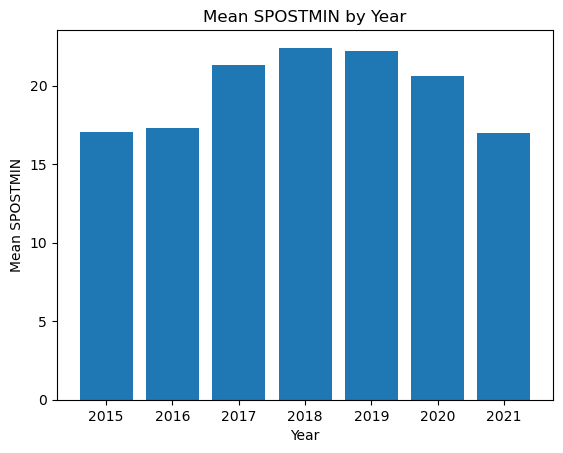

In [30]:
df_main_year = df_int_time_p_main.copy()  # Create a copy
plt.bar(df_main_year.groupby('YEAR')['SPOSTMIN'].mean().index, df_main_year.groupby('YEAR')['SPOSTMIN'].mean().values)
plt.xlabel('Year')
plt.ylabel('Mean SPOSTMIN')
plt.title('Mean SPOSTMIN by Year')
plt.show()

Hou er rekening mee dat dit de Posted Times zijn voor 2020 wanneer het park WEL open was.

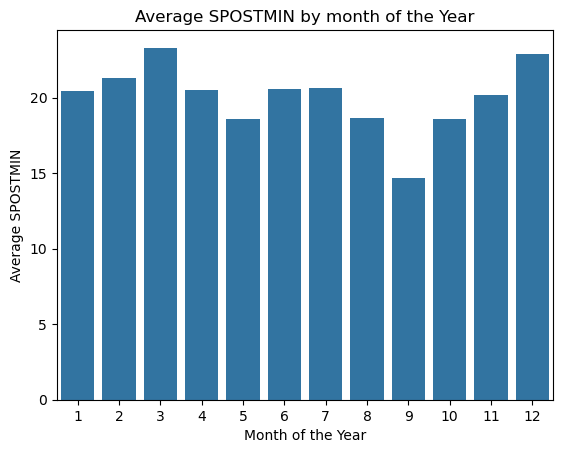

In [31]:
df_main_month = df_int_time_p_main.copy()
month_avg = df_main_month.groupby("MONTHOFYEAR")["SPOSTMIN"].mean().reset_index().copy()
ax = sns.barplot(x="MONTHOFYEAR", y="SPOSTMIN", data=month_avg)
ax.set_title("Average SPOSTMIN by month of the Year")
ax.set(xlabel="Month of the Year", ylabel="Average SPOSTMIN")
plt.xticks()
plt.show()

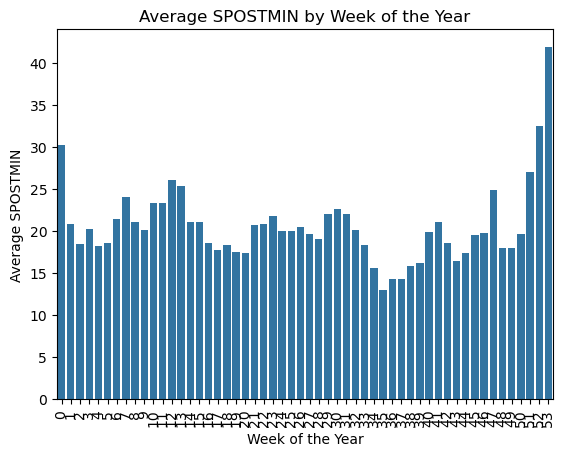

In [32]:
df_main_week = df_int_time_p_main.copy()
week_avg = df_main_week.groupby("WEEKOFYEAR")["SPOSTMIN"].mean().reset_index().copy()
ax = sns.barplot(x="WEEKOFYEAR", y="SPOSTMIN", data=week_avg)
ax.set_title("Average SPOSTMIN by Week of the Year")
ax.set(xlabel="Week of the Year", ylabel="Average SPOSTMIN")
plt.xticks(rotation=90)
plt.show()

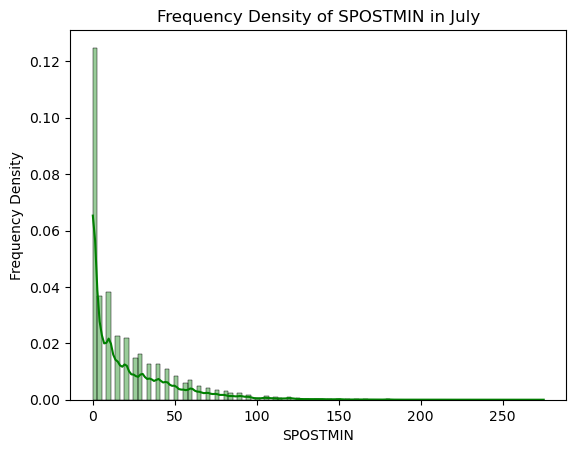

In [33]:
df_main_july = df_int_time_p_main.copy()
july = df_main_july[df_main_july['MONTHOFYEAR'] == 7].copy()
sns.histplot(july['SPOSTMIN'].dropna(), color='g', bins=100, stat='density', alpha=0.4, kde=True)
plt.xlabel('SPOSTMIN')
plt.ylabel('Frequency Density')
plt.title('Frequency Density of SPOSTMIN in July')
plt.show()

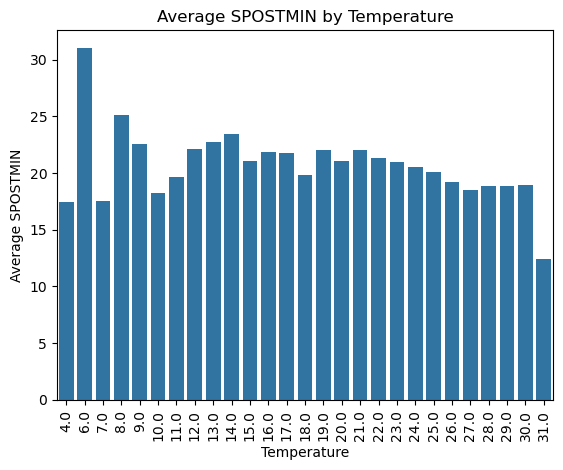

In [34]:
# change bin sizes

df_weather_temp = df_int_time_p_weather.copy()
df_weather_temp['WDWMEANTEMP'] = df_weather_temp['WDWMEANTEMP'].round().copy()
avg_temp = df_weather_temp.groupby("WDWMEANTEMP")["SPOSTMIN"].mean().reset_index().copy()
ax = sns.barplot(x="WDWMEANTEMP", y="SPOSTMIN", data=avg_temp)
ax.set_title("Average SPOSTMIN by Temperature")
ax.set(xlabel="Temperature", ylabel="Average SPOSTMIN")
plt.xticks(rotation=90)
plt.show()

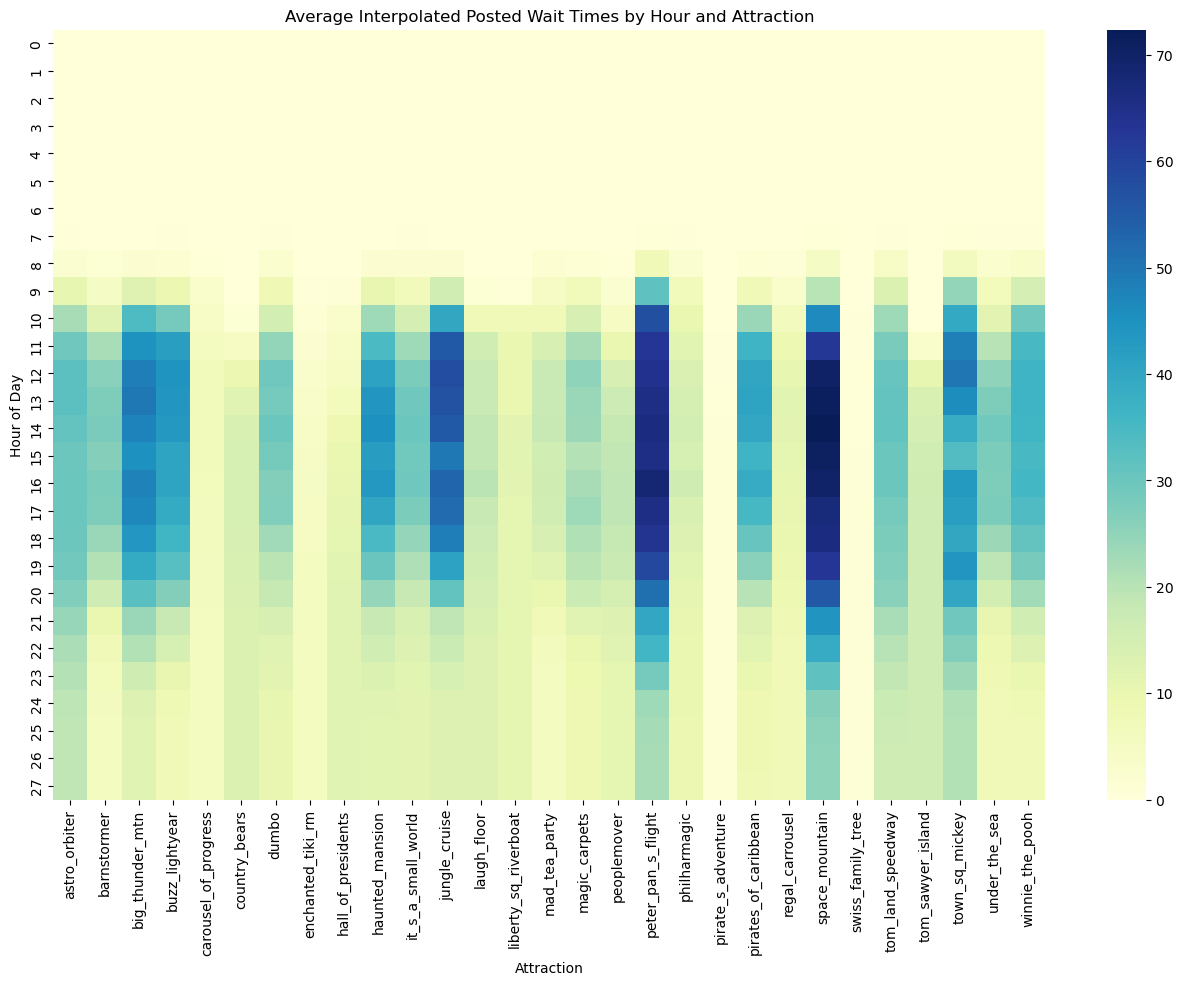

In [35]:
# draai y-as

df_entities_hour = df_itp_entities.copy()
df_entities_hour['hour'] = (df_entities_hour['minute'] // 60).astype(int)
pivot_table = df_entities_hour.pivot_table(values='SPOSTMIN', index='hour', columns='merge_name', aggfunc='mean')
plt.figure(figsize=(16, 10))
sns.heatmap(pivot_table, cmap='YlGnBu')
plt.title('Average Interpolated Posted Wait Times by Hour and Attraction')
plt.xlabel('Attraction')
plt.ylabel('Hour of Day')
plt.show()

Visuals for selected attraction(s)

In [36]:
chosen_attraction = 'space_mountain'
popular_atts = ["buzz_lightyear", "space_mountain", "peter_pan_s_flight"]
chosen_day = '2018-07-15'

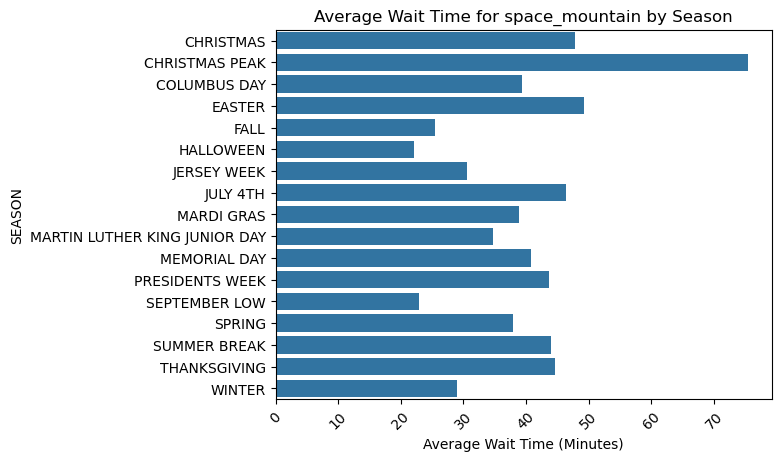

In [37]:
df_main_attraction = df_int_time_p_main.copy()
chosen_attraction = 'space_mountain'
attraction_data = df_main_attraction[df_main_attraction['attraction'] == chosen_attraction].copy()
seasonal_avg = attraction_data.groupby("SEASON")["SPOSTMIN"].mean().reset_index().copy()
ax = sns.barplot(x="SPOSTMIN", y="SEASON", data=seasonal_avg)
ax.set(xlabel='Average Wait Time (Minutes)', ylabel='SEASON', title=f'Average Wait Time for {chosen_attraction} by Season')
plt.xticks(rotation=45)
plt.show()


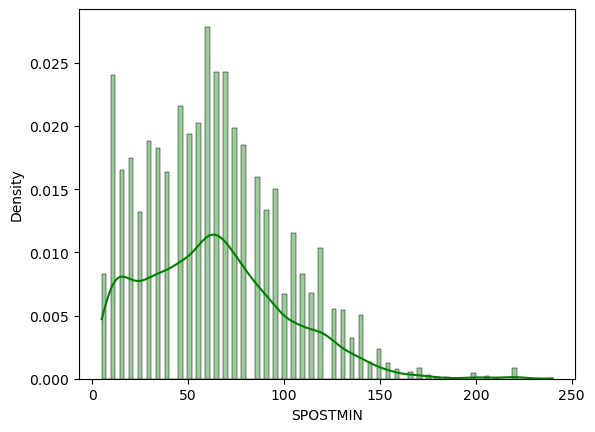

In [38]:
df_main_attraction_july = df_int_time_p_main.copy()
attraction_data_july = df_main_attraction_july[df_main_attraction_july['attraction'] == chosen_attraction].copy()
july_attraction = attraction_data_july[attraction_data_july['MONTHOFYEAR'] == 7].copy()
july_attraction = july_attraction[july_attraction['SPOSTMIN'] != 0].copy()
sns.histplot(july_attraction['SPOSTMIN'].dropna(), color='g', bins=100, stat='density', alpha=0.4, kde=True)
plt.xlabel('SPOSTMIN')
plt.show()

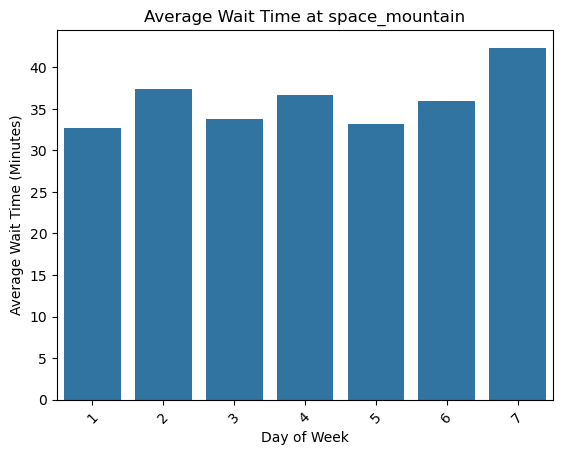

In [39]:
df_attraction_data = df_int_time_p_main.copy() #make copy

attraction_data = df_attraction_data[df_attraction_data['attraction'] == chosen_attraction].copy() #make copy

# Group by day and calculate the mean SPOSTMIN
day_attraction = attraction_data.groupby('DAYOFWEEK')['SPOSTMIN'].mean().reset_index().copy() #make copy

# Create the bar plot
ax = sns.barplot(x="DAYOFWEEK", y="SPOSTMIN", data=day_attraction)

# Set labels and title
ax.set(xlabel='Day of Week', ylabel='Average Wait Time (Minutes)', title=f'Average Wait Time at {chosen_attraction}')

# Rotate x-axis labels
plt.xticks(rotation=45)

# Show the plot
plt.show()

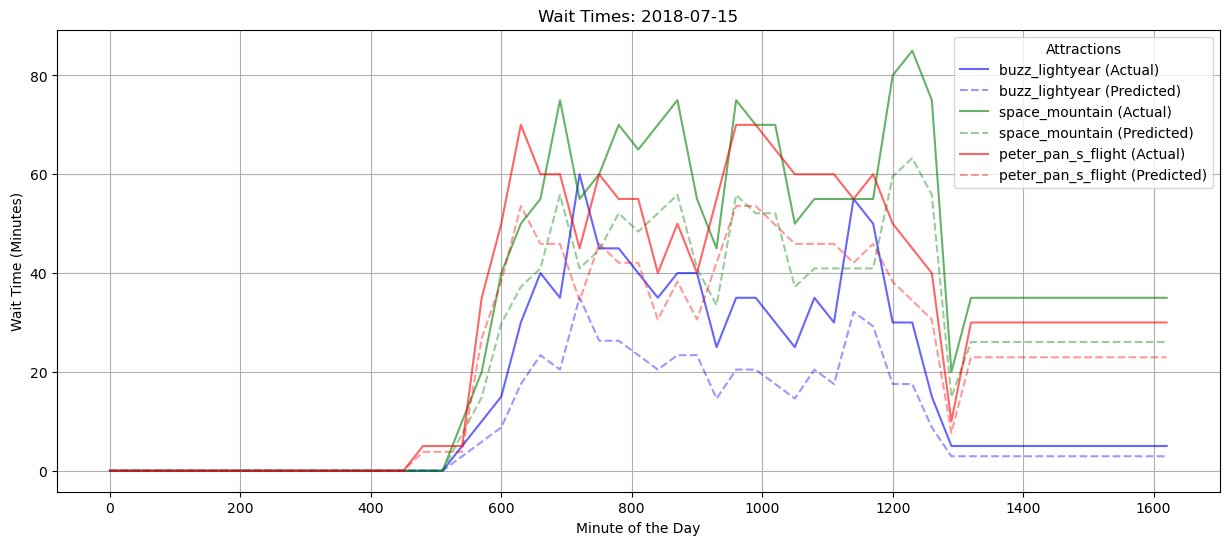

In [40]:
df_main_chosen = df_int_time_p_main.copy()
df_pred_chosen = df_wt_pred.copy()
chosen_day = '2018-07-15'
popular_atts = ["buzz_lightyear", "space_mountain", "peter_pan_s_flight"]
df_chosen = df_main_chosen[(df_main_chosen["date"] == chosen_day) & (df_main_chosen["attraction"].isin(popular_atts))].copy()
df_pred_chosen = df_pred_chosen[(df_pred_chosen["date"] == chosen_day) & (df_pred_chosen["attraction"].isin(popular_atts))].copy()
plt.figure(figsize=(15, 6))
colors = ['blue', 'green', 'red']
for i, attraction in enumerate(popular_atts):
    attraction_data_main = df_chosen[df_chosen["attraction"] == attraction].copy()
    attraction_data_pred = df_pred_chosen[df_pred_chosen["attraction"] == attraction].copy()
    plt.plot(attraction_data_main["minute"], attraction_data_main["SPOSTMIN"], label=f"{attraction} (Actual)", color=colors[i], alpha=0.6)
    plt.plot(attraction_data_pred["minute"], attraction_data_pred["predicted_actual_time"], label=f"{attraction} (Predicted)", color=colors[i], linestyle='--', alpha=0.4)
plt.title(f"Wait Times: {chosen_day}")
plt.xlabel("Minute of the Day")
plt.ylabel("Wait Time (Minutes)")
plt.legend(title="Attractions")
plt.grid()
plt.show()

,attraction,SEASON,SPOSTMIN
0,alien_saucers,CHRISTMAS,120.0
1,alien_saucers,CHRISTMAS PEAK,130.0
2,alien_saucers,COLUMBUS DAY,70.0
3,alien_saucers,EASTER,85.0
4,alien_saucers,FALL,70.0
...,...,...,...
670,winnie_the_pooh,SEPTEMBER LOW,65.0
671,winnie_the_pooh,SPRING,85.0
672,winnie_the_pooh,SUMMER BREAK,70.0
673,winnie_the_pooh,THANKSGIVING,85.0


C:\Users\masha\AppData\Local\Temp\ipykernel_20648\1592606195.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  date_of_max_wait = df_main_copy.groupby(['attraction', 'SEASON']).apply(find_date_of_max_wait).copy() #copy the apply operation


attraction       SEASON        
alien_saucers    CHRISTMAS        2018-12-24
                 CHRISTMAS PEAK   2018-12-29
                 COLUMBUS DAY     2018-10-06
                 EASTER           2019-04-16
                 FALL             2018-10-18
                                     ...    
winnie_the_pooh  SEPTEMBER LOW    2018-08-23
                 SPRING           2018-03-14
                 SUMMER BREAK     2015-08-06
                 THANKSGIVING     2015-11-23
                 WINTER           2017-12-14
Length: 675, dtype: datetime64[ns]

C:\Users\masha\AppData\Local\Temp\ipykernel_20648\1592606195.py:27: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout(rect=[0, 0, 0.1, 0.1])  # Adjust layout to accommodate the legend


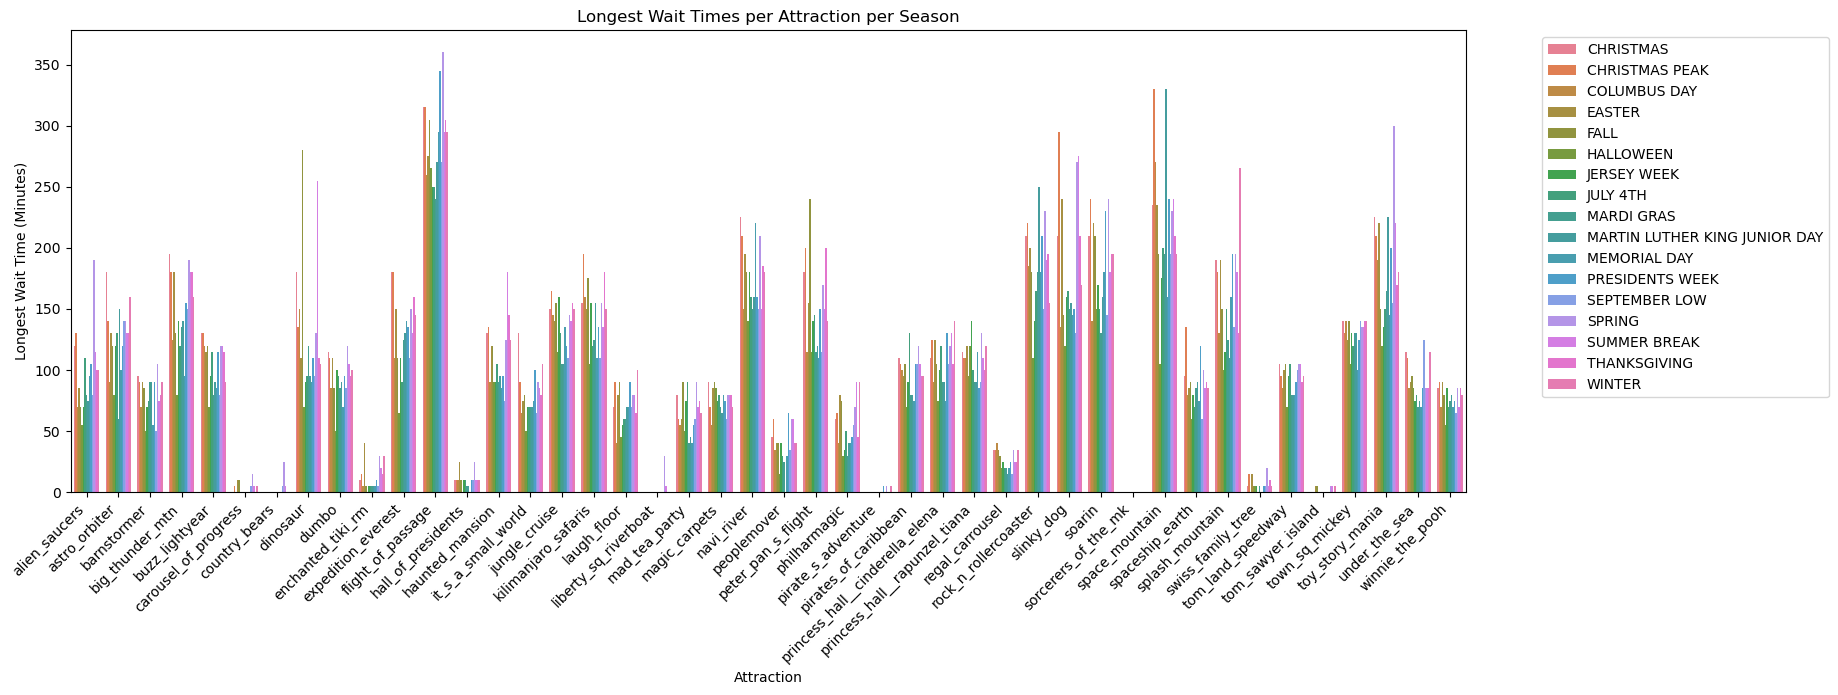

In [41]:
df_main_copy = df_int_time_p_main.copy()  # Create a copy

longest_wait_times = df_main_copy.groupby(['attraction', 'SEASON'])['SPOSTMIN'].max().copy() #copy the group by operation

longest_wait_times_df = longest_wait_times.reset_index().copy() #copy the reset index dataframe

display(longest_wait_times_df)

def find_date_of_max_wait(df):
    max_index = df['SPOSTMIN'].idxmax()
    return df.loc[max_index, 'date']

date_of_max_wait = df_main_copy.groupby(['attraction', 'SEASON']).apply(find_date_of_max_wait).copy() #copy the apply operation

display(date_of_max_wait)

plt.figure(figsize=(18, 6))
ax = sns.barplot(x='attraction', y='SPOSTMIN', hue='SEASON', data=longest_wait_times_df)
plt.title('Longest Wait Times per Attraction per Season')
plt.xlabel('Attraction')
plt.ylabel('Longest Wait Time (Minutes)')
plt.xticks(rotation=45, ha='right')

# Move the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout(rect=[0, 0, 0.1, 0.1])  # Adjust layout to accommodate the legend
plt.show()

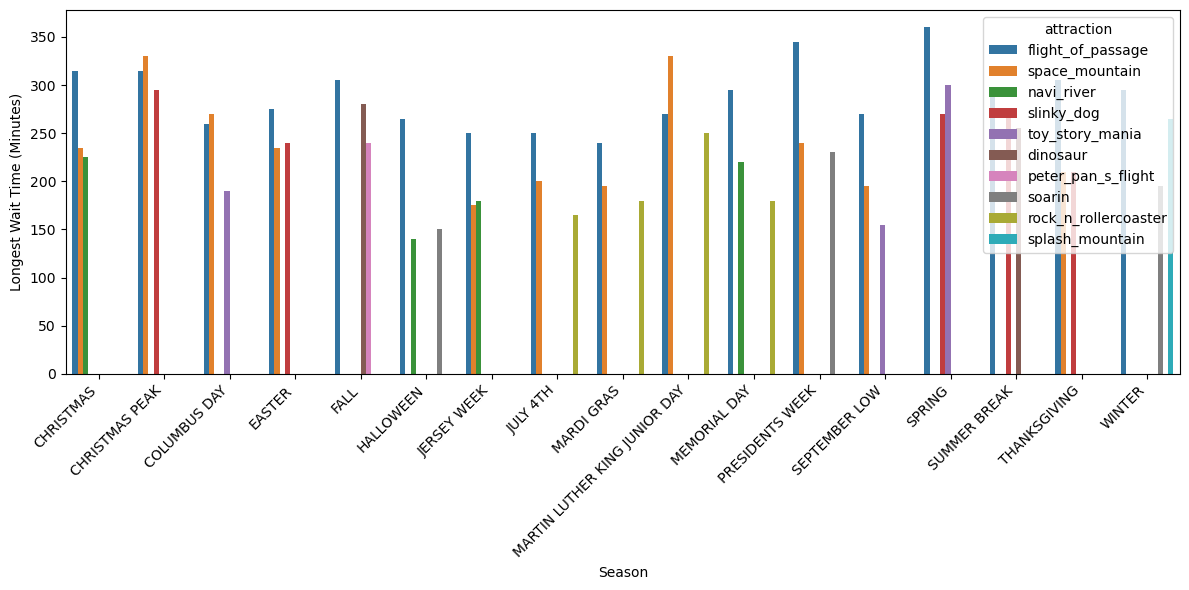

In [42]:
df_main_longest = df_int_time_p_main.copy()
longest_wait_times = df_main_longest.groupby(['SEASON', 'attraction'])['SPOSTMIN'].max().reset_index().copy()
top_3_attractions = pd.DataFrame()
for season, group in longest_wait_times.groupby('SEASON'):
    top_3 = group.nlargest(3, 'SPOSTMIN')
    top_3_attractions = pd.concat([top_3_attractions, top_3])
plt.figure(figsize=(12, 6))
sns.barplot(x='SEASON', y='SPOSTMIN', hue='attraction', data=top_3_attractions)
plt.xlabel('Season')
plt.ylabel('Longest Wait Time (Minutes)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Busiest Days:


,SEASON,attraction,busiest_day,busiest_avg_wait
0,CHRISTMAS PEAK,astro_orbiter,2017-12-27,34.090909
0,CHRISTMAS PEAK,barnstormer,2019-12-31,31.181818
0,CHRISTMAS PEAK,big_thunder_mtn,2018-12-31,71.545455
0,CHRISTMAS PEAK,buzz_lightyear,2019-12-31,46.727273
0,CHRISTMAS PEAK,dinosaur,2016-12-29,41.909091
...,...,...,...,...
0,MARDI GRAS,flight_of_passage,2018-02-12,139.454545
0,MARDI GRAS,navi_river,2018-02-12,52.818182
0,MARDI GRAS,peoplemover,2019-03-06,10.636364
0,MARDI GRAS,alien_saucers,2019-03-03,22.454545



Slowest Days:


,SEASON,attraction,slowest_day,slowest_avg_wait
0,CHRISTMAS PEAK,astro_orbiter,2018-01-01,10.181818
0,CHRISTMAS PEAK,barnstormer,2018-01-01,4.727273
0,CHRISTMAS PEAK,big_thunder_mtn,2018-01-01,14.000000
0,CHRISTMAS PEAK,buzz_lightyear,2017-01-01,15.727273
0,CHRISTMAS PEAK,dinosaur,2018-12-31,13.090909
...,...,...,...,...
0,MARDI GRAS,flight_of_passage,2019-03-05,66.272727
0,MARDI GRAS,navi_river,2019-03-05,32.090909
0,MARDI GRAS,peoplemover,2019-03-04,1.454545
0,MARDI GRAS,alien_saucers,2019-03-05,18.545455


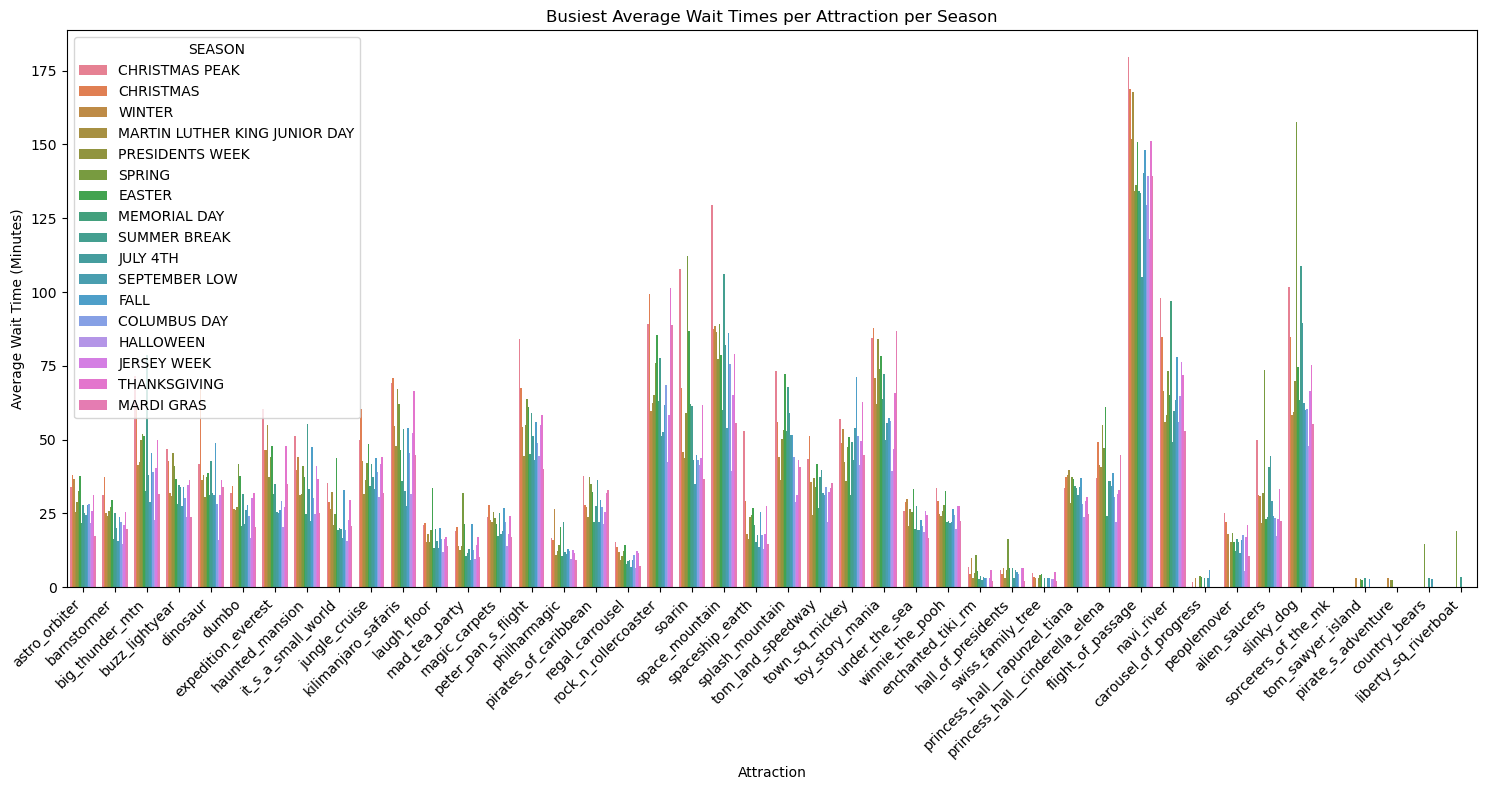

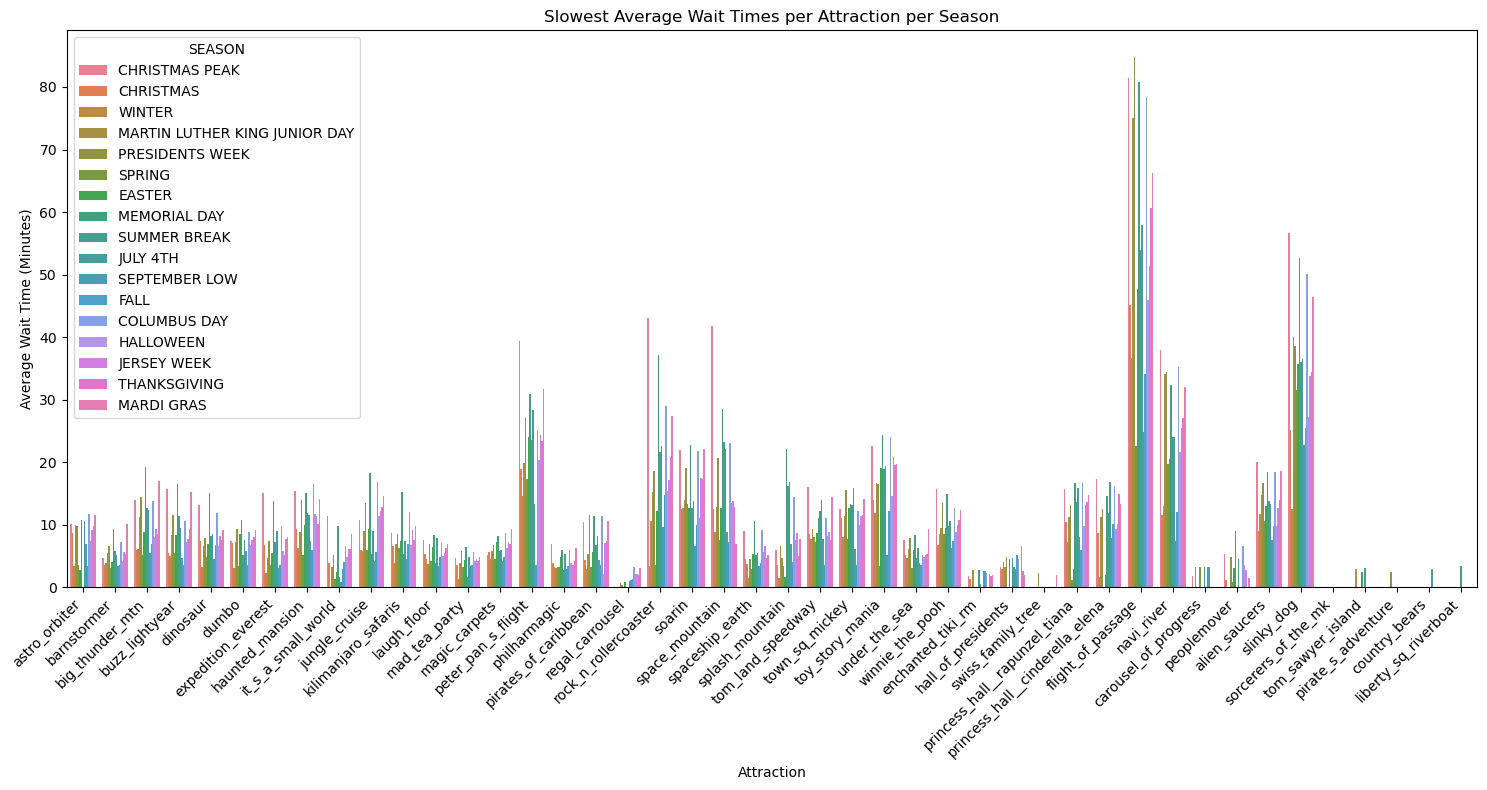

In [43]:
df_main_busy_slow = df_int_time_p_main.copy()
busiest_days = pd.DataFrame()
slowest_days = pd.DataFrame()
for season in df_main_busy_slow['SEASON'].unique():
    season_df = df_main_busy_slow[df_main_busy_slow['SEASON'] == season].copy()
    for att in df_main_busy_slow['attraction'].unique():
        att_df = season_df[season_df['attraction'] == att].copy()
        if not att_df.empty:
            avg_wait_per_day = att_df.groupby('date')['SPOSTMIN'].mean().copy()
            busiest_day = avg_wait_per_day.idxmax()
            busiest_wait = att_df[att_df['date'] == busiest_day]['SPOSTMIN'].mean()
            busiest_days = pd.concat([busiest_days, pd.DataFrame({'SEASON': [season], 'attraction': [att], 'busiest_day': [busiest_day], 'busiest_avg_wait': [busiest_wait]})])
            slowest_day = avg_wait_per_day.idxmin()
            slowest_wait = att_df[att_df['date'] == slowest_day]['SPOSTMIN'].mean()
            slowest_days = pd.concat([slowest_days, pd.DataFrame({'SEASON': [season], 'attraction': [att], 'slowest_day': [slowest_day], 'slowest_avg_wait': [slowest_wait]})])
print("Busiest Days:")
display(busiest_days)
print("\nSlowest Days:")
display(slowest_days)
plt.figure(figsize=(15, 8))
sns.barplot(x='attraction', y='busiest_avg_wait', hue='SEASON', data=busiest_days)
plt.title('Busiest Average Wait Times per Attraction per Season')
plt.xlabel('Attraction')
plt.ylabel('Average Wait Time (Minutes)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
plt.figure(figsize=(15, 8))
sns.barplot(x='attraction', y='slowest_avg_wait', hue='SEASON', data=slowest_days)
plt.title('Slowest Average Wait Times per Attraction per Season')
plt.xlabel('Attraction')
plt.ylabel('Average Wait Time (Minutes)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

C:\Users\masha\AppData\Local\Temp\ipykernel_20648\2697056086.py:16: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_3_busiest = busiest_days_top_3.groupby('attraction').apply(lambda x: x.nlargest(3, 'busiest_avg_wait')).reset_index(drop=True).copy()
C:\Users\masha\AppData\Local\Temp\ipykernel_20648\2697056086.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_3_slowest = slowest_days_top_3.groupby('

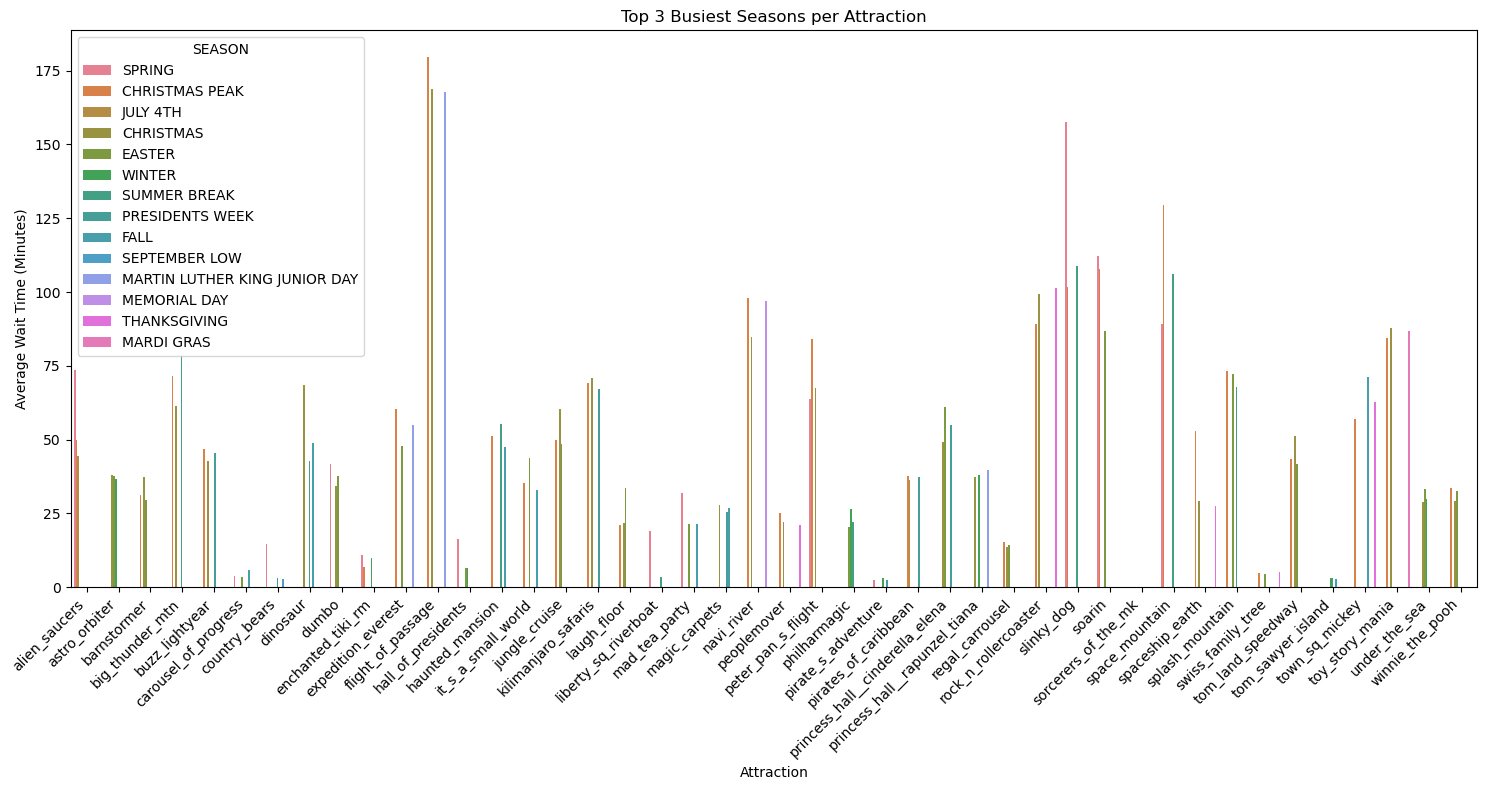

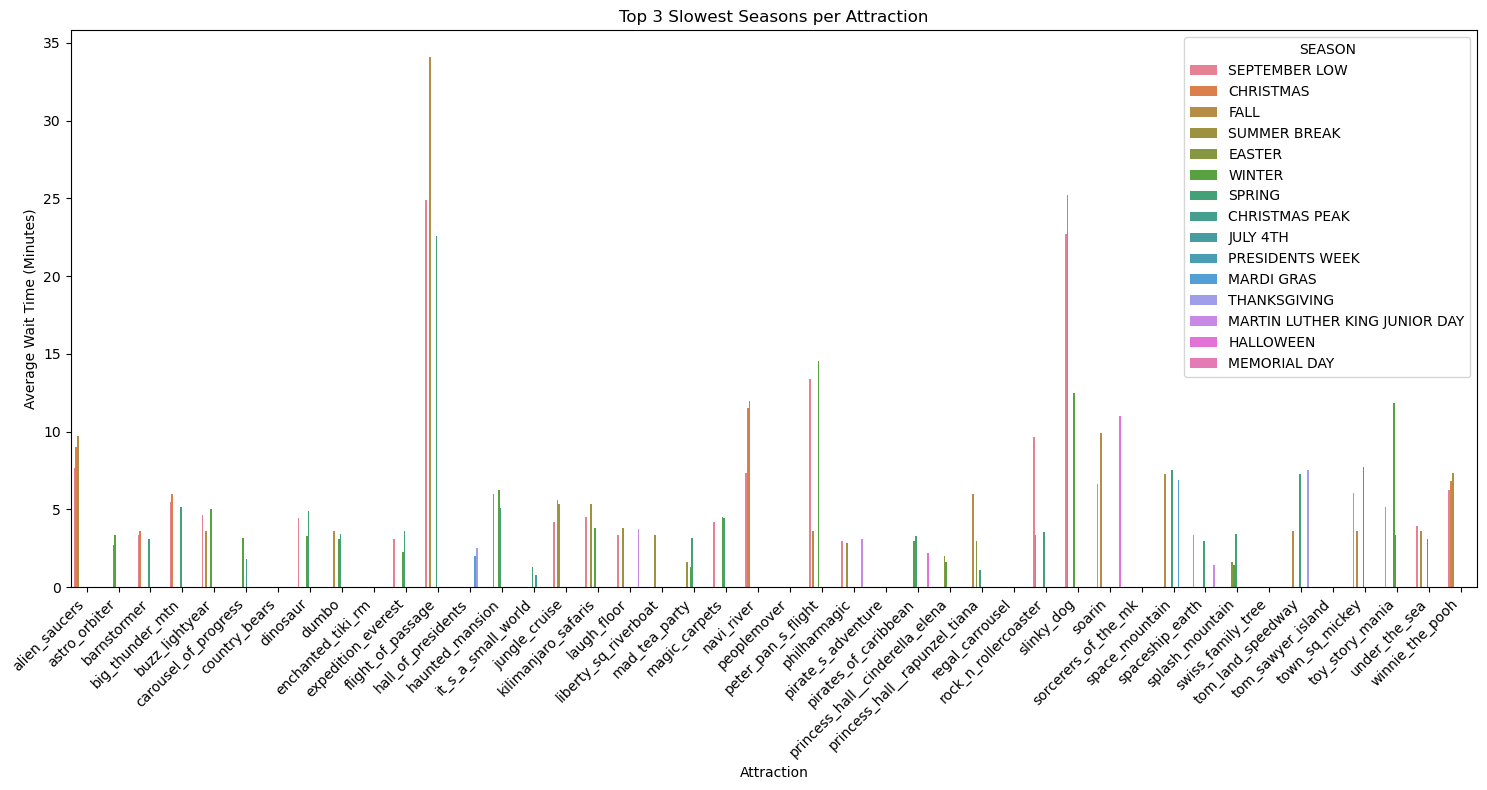

In [44]:
df_main_top_3 = df_int_time_p_main.copy()
busiest_days_top_3 = pd.DataFrame()
slowest_days_top_3 = pd.DataFrame()
for season in df_main_top_3['SEASON'].unique():
    season_df_top_3 = df_main_top_3[df_main_top_3['SEASON'] == season].copy()
    for att in df_main_top_3['attraction'].unique():
        att_df_top_3 = season_df_top_3[season_df_top_3['attraction'] == att].copy()
        if not att_df_top_3.empty:
            avg_wait_per_day_top_3 = att_df_top_3.groupby('date')['SPOSTMIN'].mean().copy()
            busiest_day_top_3 = avg_wait_per_day_top_3.idxmax()
            busiest_wait_top_3 = att_df_top_3[att_df_top_3['date'] == busiest_day_top_3]['SPOSTMIN'].mean()
            busiest_days_top_3 = pd.concat([busiest_days_top_3, pd.DataFrame({'SEASON': [season], 'attraction': [att], 'busiest_day': [busiest_day_top_3], 'busiest_avg_wait': [busiest_wait_top_3]})])
            slowest_day_top_3 = avg_wait_per_day_top_3.idxmin()
            slowest_wait_top_3 = att_df_top_3[att_df_top_3['date'] == slowest_day_top_3]['SPOSTMIN'].mean()
            slowest_days_top_3 = pd.concat([slowest_days_top_3, pd.DataFrame({'SEASON': [season], 'attraction': [att], 'slowest_day': [slowest_day_top_3], 'slowest_avg_wait': [slowest_wait_top_3]})])
top_3_busiest = busiest_days_top_3.groupby('attraction').apply(lambda x: x.nlargest(3, 'busiest_avg_wait')).reset_index(drop=True).copy()
top_3_slowest = slowest_days_top_3.groupby('attraction').apply(lambda x: x.nsmallest(3, 'slowest_avg_wait')).reset_index(drop=True).copy()
plt.figure(figsize=(15, 8))
sns.barplot(x='attraction', y='busiest_avg_wait', hue='SEASON', data=top_3_busiest)
plt.title('Top 3 Busiest Seasons per Attraction')
plt.xlabel('Attraction')
plt.ylabel('Average Wait Time (Minutes)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
plt.figure(figsize=(15, 8))
sns.barplot(x='attraction', y='slowest_avg_wait', hue='SEASON', data=top_3_slowest)
plt.title('Top 3 Slowest Seasons per Attraction')
plt.xlabel('Attraction')
plt.ylabel('Average Wait Time (Minutes)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

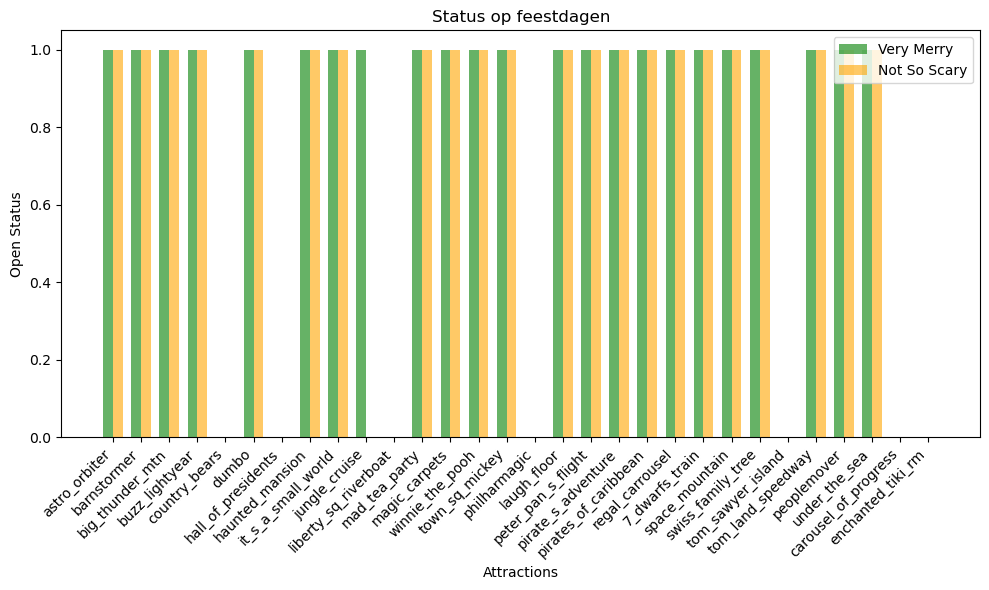

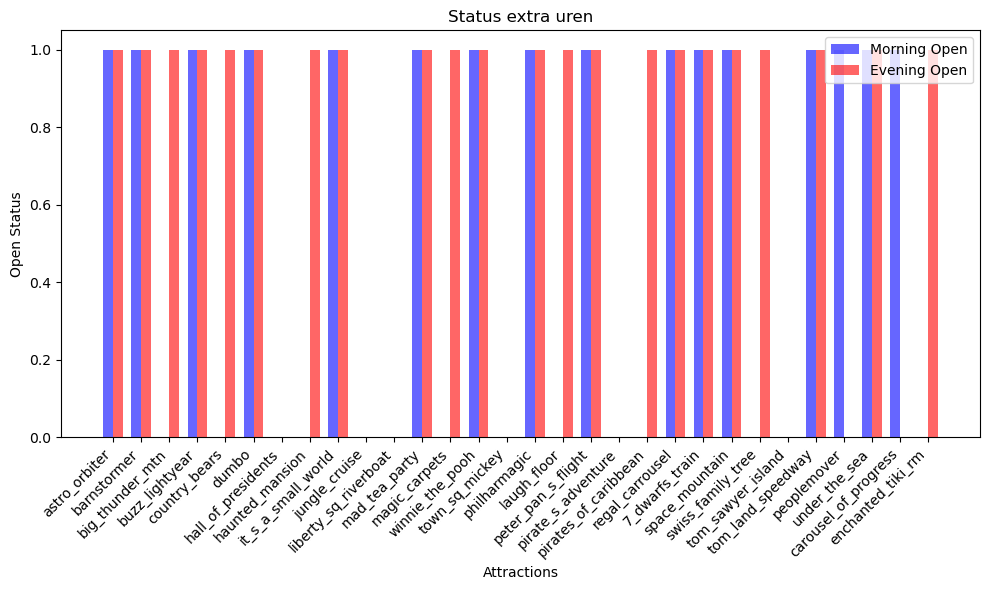

In [45]:
df_entities_extra_merry = df_entities_extra_filtered.copy()
df_entities_extra_merry['open_very_merry'] = df_entities_extra_merry['open_very_merry'].astype(int)
df_entities_extra_merry['open_not_so_scary'] = df_entities_extra_merry['open_not_so_scary'].astype(int)
x = np.arange(len(df_entities_extra_merry['merge_name']))
width = 0.35
plt.figure(figsize=(10, 6))
plt.bar(x - width/2, df_entities_extra_merry['open_very_merry'], width, label='Very Merry', color='green', alpha=0.6)
plt.bar(x + width/2, df_entities_extra_merry['open_not_so_scary'], width, label='Not So Scary', color='orange', alpha=0.6)
plt.title('Status op feestdagen')
plt.xlabel('Attractions')
plt.ylabel('Open Status')
plt.xticks(x, df_entities_extra_merry['merge_name'], rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

df_entities_extra_emh = df_entities_extra_filtered.copy()
df_entities_extra_emh['open_emh_morning'] = df_entities_extra_emh['open_emh_morning'].astype(int)
df_entities_extra_emh['open_emh_evening'] = df_entities_extra_emh['open_emh_evening'].astype(int)
x = np.arange(len(df_entities_extra_emh['merge_name']))
width = 0.35
plt.figure(figsize=(10, 6))
plt.bar(x - width/2, df_entities_extra_emh['open_emh_morning'], width, label='Morning Open', color='blue', alpha=0.6)
plt.bar(x + width/2, df_entities_extra_emh['open_emh_evening'], width, label='Evening Open', color='red', alpha=0.6)
plt.title('Status extra uren')
plt.xlabel('Attractions')
plt.ylabel('Open Status')
plt.xticks(x, df_entities_extra_emh['merge_name'], rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

,month,longest_wait_day,longest_wait
0,2015-01,2015-01-02,25.538961
0,2015-02,2015-02-14,24.973064
0,2015-03,2015-03-31,34.308442
0,2015-04,2015-04-07,31.613636
0,2015-05,2015-05-24,22.957792
...,...,...,...
0,2021-04,2021-04-30,14.738292
0,2021-05,2021-05-11,18.595041
0,2021-06,2021-06-30,20.426997
0,2021-07,2021-07-29,27.014663


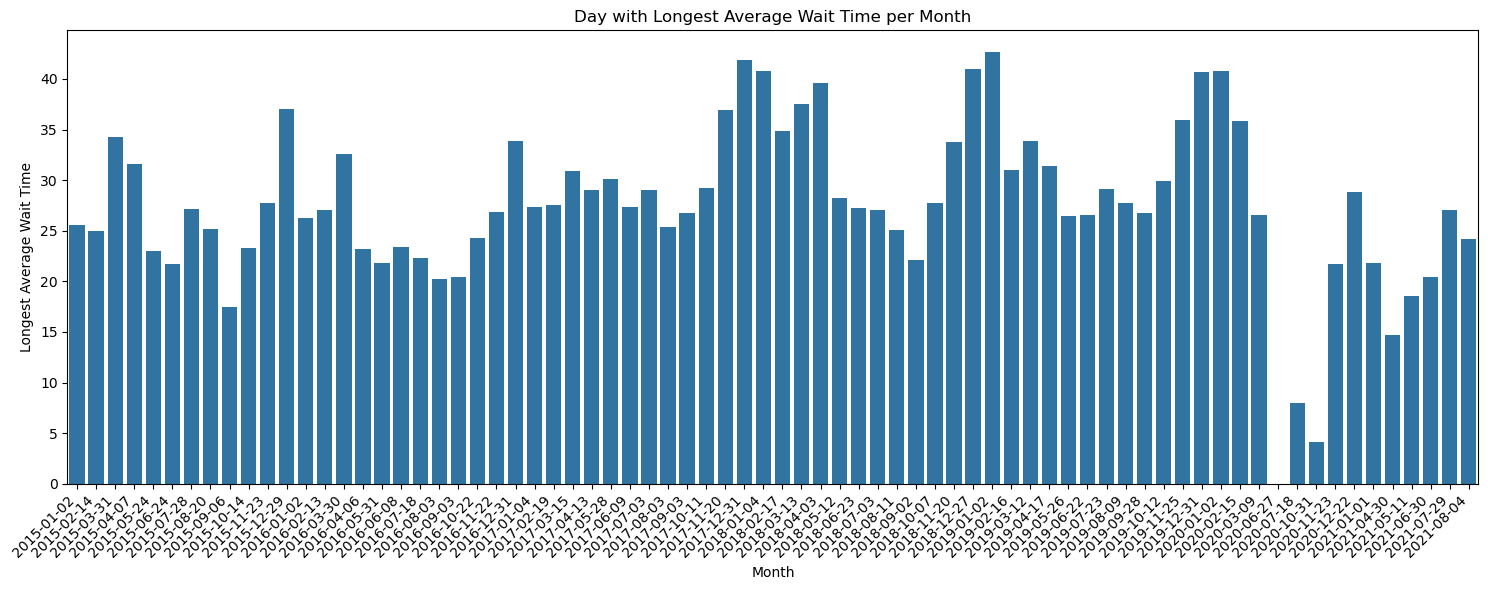

In [46]:
df_main_month_longest = df_int_time_p_main.copy()
df_main_month_longest['date'] = pd.to_datetime(df_main_month_longest['date'])
df_main_month_longest['MONTH'] = df_main_month_longest['date'].dt.to_period('M')
longest_wait_days_per_month = pd.DataFrame()
for month, group in df_main_month_longest.groupby('MONTH'):
    avg_wait_per_day = group.groupby('date')['SPOSTMIN'].mean().copy()
    longest_wait_day = avg_wait_per_day.idxmax()
    longest_wait = avg_wait_per_day.max()
    longest_wait_days_per_month = pd.concat([longest_wait_days_per_month, pd.DataFrame({'month': [month], 'longest_wait_day': [longest_wait_day], 'longest_wait': [longest_wait]})])
display(longest_wait_days_per_month)
plt.figure(figsize=(15, 6))
sns.barplot(x='longest_wait_day', y='longest_wait', data=longest_wait_days_per_month)
plt.title('Day with Longest Average Wait Time per Month')
plt.xlabel('Month')
plt.ylabel('Longest Average Wait Time')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

,month,shortest_wait_day,shortest_wait
0,2015-01,2015-01-12,9.818182
0,2015-02,2015-02-05,9.208754
0,2015-03,2015-03-04,10.080420
0,2015-04,2015-04-28,10.101399
0,2015-05,2015-05-13,11.224026
...,...,...,...
0,2021-04,2021-04-30,14.738292
0,2021-05,2021-05-23,13.935065
0,2021-06,2021-06-20,12.671123
0,2021-07,2021-07-03,14.886364


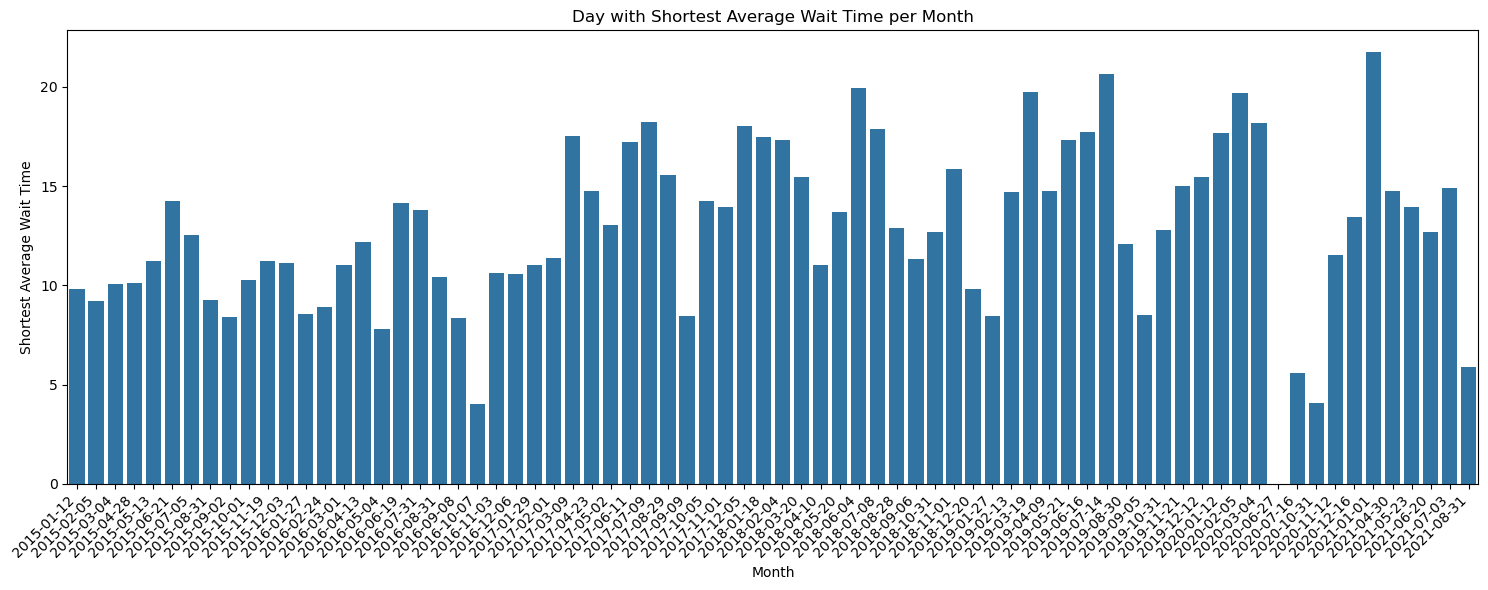

In [47]:
df_main_copy = df_int_time_p_main.copy() #copy the original dataframe

df_main_copy['date'] = pd.to_datetime(df_main_copy['date']) #copy the date conversion
df_main_copy['MONTH'] = df_main_copy['date'].dt.to_period('M').copy() #copy the month creation

shortest_wait_days_per_month = pd.DataFrame()
for month, group in df_main_copy.groupby('MONTH'):
    avg_wait_per_day = group.groupby('date')['SPOSTMIN'].mean().copy() #copy the group by mean
    shortest_wait_day = avg_wait_per_day.idxmin()
    shortest_wait = avg_wait_per_day.min()
    shortest_wait_days_per_month = pd.concat([shortest_wait_days_per_month, pd.DataFrame({
        'month': [month],
        'shortest_wait_day': [shortest_wait_day],
        'shortest_wait': [shortest_wait]
    })])

display(shortest_wait_days_per_month)

plt.figure(figsize=(15, 6))
sns.barplot(x='shortest_wait_day', y='shortest_wait', data=shortest_wait_days_per_month)
plt.title('Day with Shortest Average Wait Time per Month')
plt.xlabel('Month')
plt.ylabel('Shortest Average Wait Time')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [48]:
chosen_month = 7
chosen_year = 2018

# Create a copy of the original DataFrame to avoid overwriting
df_int_time_p_opening_month = df_int_time_p_opening.copy()

# Convert 'date' to datetime if it's not already
df_int_time_p_opening_month['date'] = pd.to_datetime(df_int_time_p_opening_month['date'])

# Filter based on chosen_month and chosen_year
filtered_df = df_int_time_p_opening_month[(df_int_time_p_opening_month['date'].dt.year == chosen_year) & 
                                     (df_int_time_p_opening_month['date'].dt.month == chosen_month)].copy() # copy filtered

# Explicitly define the columns you want
desired_columns = ['date', 'DAYOFWEEK', 'DAYOFYEAR', 'WEEKOFYEAR', 'MONTHOFYEAR', 'YEAR',
                          'MKOPEN', 'MKCLOSE', 'MKHOURS',
                          'EPOPEN', 'EPCLOSE', 'EPHOURS',
                          'HSOPEN', 'HSCLOSE', 'HSHOURS',
                          'AKOPEN', 'AKCLOSE', 'AKHOURS']

# Create a new DataFrame with only the desired columns
opening_hours_per_park = filtered_df[desired_columns].copy()

# Display the result
display(opening_hours_per_park)

,date,DAYOFWEEK,DAYOFYEAR,WEEKOFYEAR,MONTHOFYEAR,YEAR,MKOPEN,MKCLOSE,MKHOURS,EPOPEN,EPCLOSE,EPHOURS,HSOPEN,HSCLOSE,HSHOURS,AKOPEN,AKCLOSE,AKHOURS
2024165,2018-07-01,1,181,26,7,2018,09:00,22:00,13.0,09:00,21:00,12.0,08:00,22:30,14.5,09:00,22:30,13.5
2024166,2018-07-01,1,181,26,7,2018,09:00,22:00,13.0,09:00,21:00,12.0,08:00,22:30,14.5,09:00,22:30,13.5
2024167,2018-07-01,1,181,26,7,2018,09:00,22:00,13.0,09:00,21:00,12.0,08:00,22:30,14.5,09:00,22:30,13.5
2024168,2018-07-01,1,181,26,7,2018,09:00,22:00,13.0,09:00,21:00,12.0,08:00,22:30,14.5,09:00,22:30,13.5
2024169,2018-07-01,1,181,26,7,2018,09:00,22:00,13.0,09:00,21:00,12.0,08:00,22:30,14.5,09:00,22:30,13.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2082075,2018-07-31,3,211,30,7,2018,09:00,23:00,14.0,09:00,21:00,12.0,08:00,22:30,14.5,09:00,22:00,13.0
2082076,2018-07-31,3,211,30,7,2018,09:00,23:00,14.0,09:00,21:00,12.0,08:00,22:30,14.5,09:00,22:00,13.0
2082077,2018-07-31,3,211,30,7,2018,09:00,23:00,14.0,09:00,21:00,12.0,08:00,22:30,14.5,09:00,22:00,13.0
2082078,2018-07-31,3,211,30,7,2018,09:00,23:00,14.0,09:00,21:00,12.0,08:00,22:30,14.5,09:00,22:00,13.0


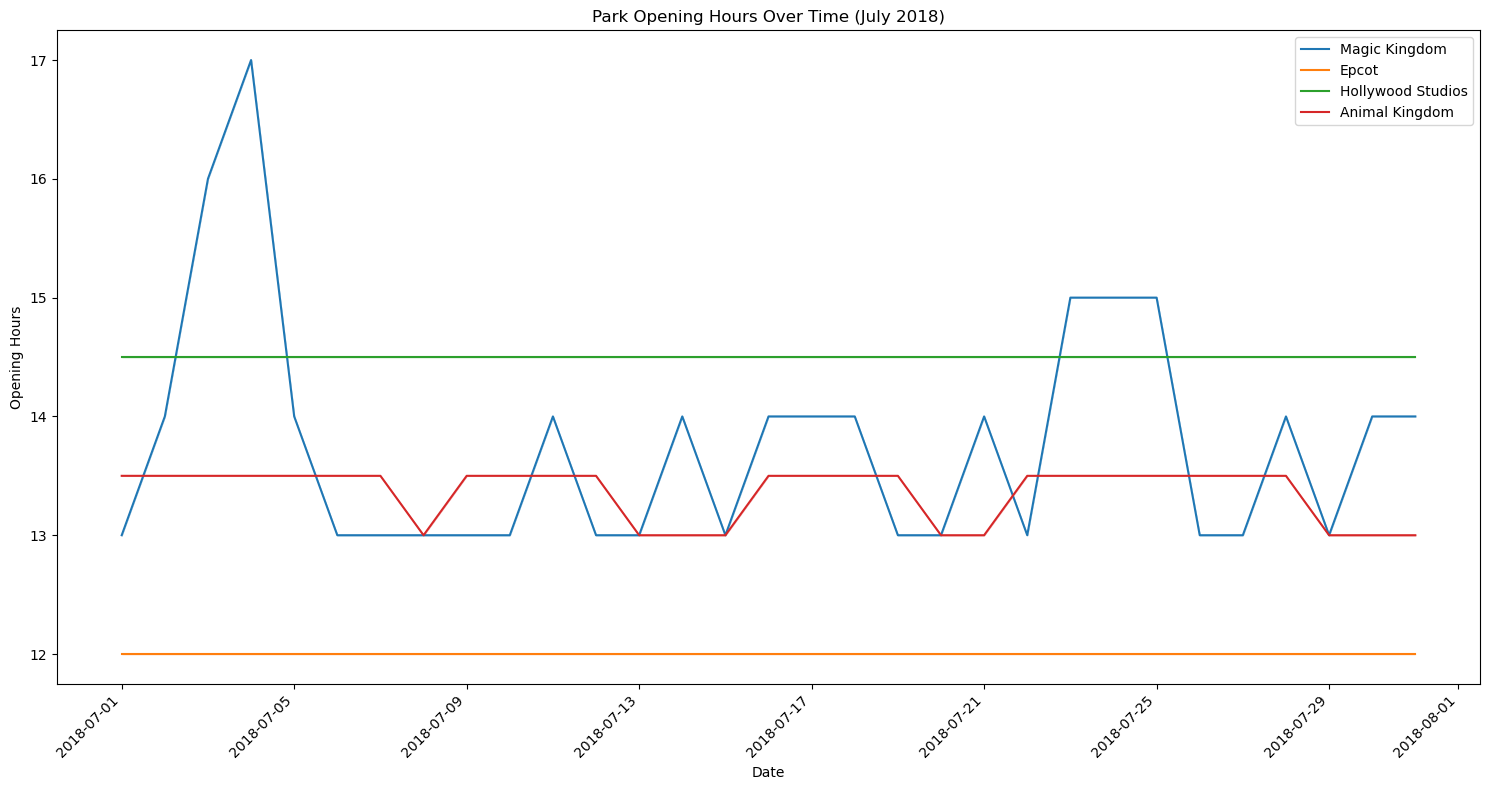

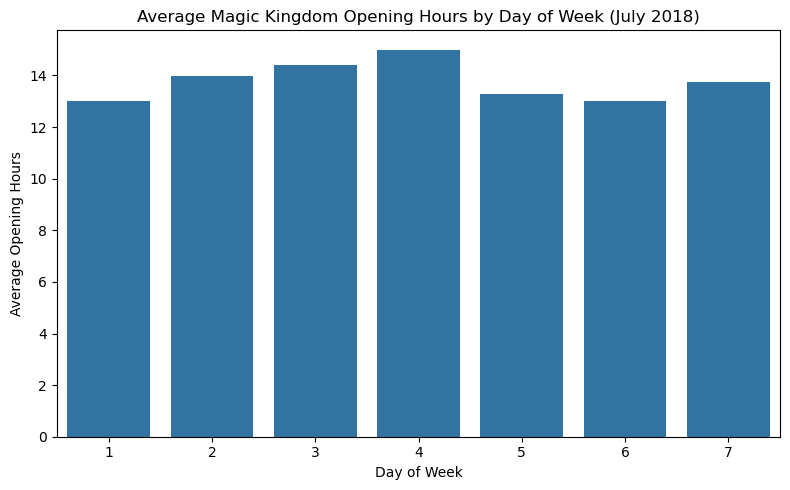

In [49]:
plt.figure(figsize=(15, 8))
sns.lineplot(x='date', y='MKHOURS', data=opening_hours_per_park, label='Magic Kingdom')
sns.lineplot(x='date', y='EPHOURS', data=opening_hours_per_park, label='Epcot')
sns.lineplot(x='date', y='HSHOURS', data=opening_hours_per_park, label='Hollywood Studios')
sns.lineplot(x='date', y='AKHOURS', data=opening_hours_per_park, label='Animal Kingdom')
plt.title('Park Opening Hours Over Time (July 2018)')
plt.xlabel('Date')
plt.ylabel('Opening Hours')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
sns.barplot(x='DAYOFWEEK', y='MKHOURS', data=opening_hours_per_park, errorbar=None) #errorbar=None removes confidence intervals
plt.title('Average Magic Kingdom Opening Hours by Day of Week (July 2018)')
plt.xlabel('Day of Week')
plt.ylabel('Average Opening Hours')
plt.tight_layout()
plt.show()

In [50]:
chosen_year = 2018  # Or any year you want

# Create a copy of the original DataFrame to avoid overwriting
df_opening_year = df_int_time_p_opening.copy()

df_opening_year['date'] = pd.to_datetime(df_opening_year['date'])
filtered_year = df_opening_year[df_opening_year['date'].dt.year == chosen_year].copy() # copy filtered

desired_year_columns = ['date', 'DAYOFWEEK', 'DAYOFYEAR', 'WEEKOFYEAR', 'MONTHOFYEAR', 'YEAR', 'MKHOURS', 'EPHOURS', 'HSHOURS', 'AKHOURS']
opening_hours_per_park_year = filtered_year[desired_year_columns].copy()

weekly_hours = opening_hours_per_park_year.groupby('WEEKOFYEAR')[['MKHOURS', 'EPHOURS', 'HSHOURS', 'AKHOURS']].sum().reset_index().copy() #copy group by

# Display the result
display(weekly_hours.head())

,WEEKOFYEAR,MKHOURS,EPHOURS,HSHOURS,AKHOURS
0,0,161920.0,126720.0,126720.0,126720.0
1,1,147290.0,143880.0,135355.0,133595.0
2,2,151745.0,143220.0,132990.0,134695.0
3,3,142120.0,143880.0,133595.0,131890.0
4,4,143055.0,144540.0,134255.0,132495.0


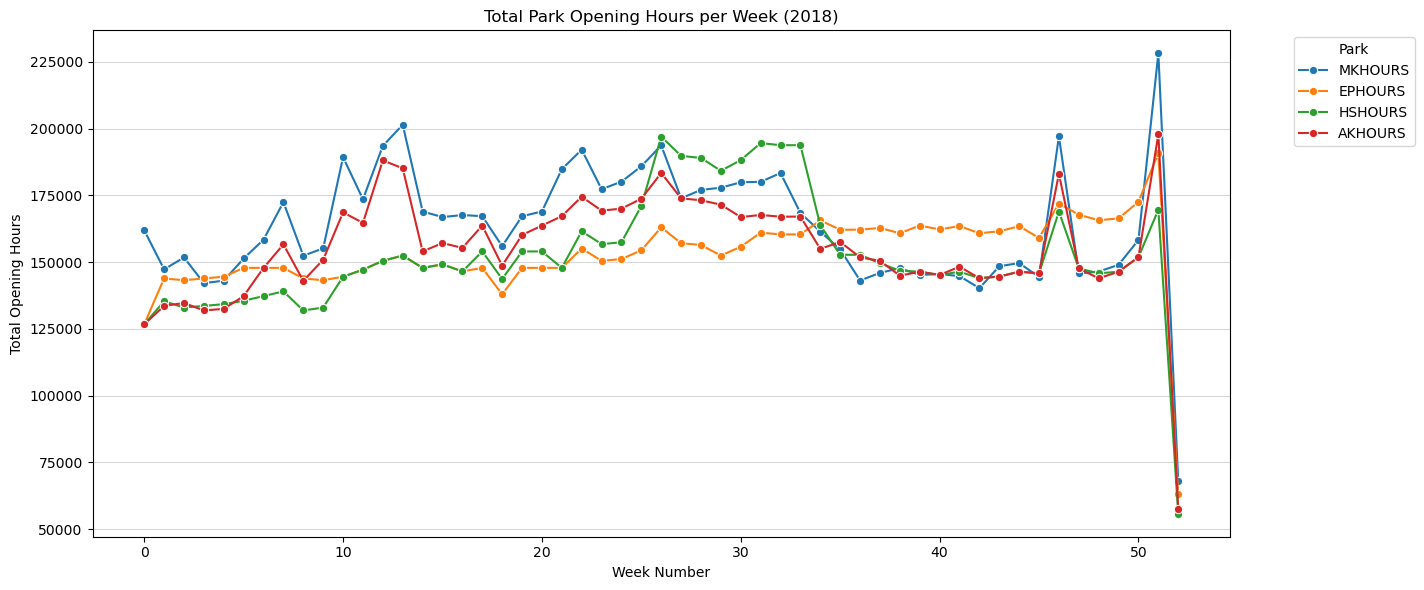

<Figure size 1600x600 with 0 Axes>

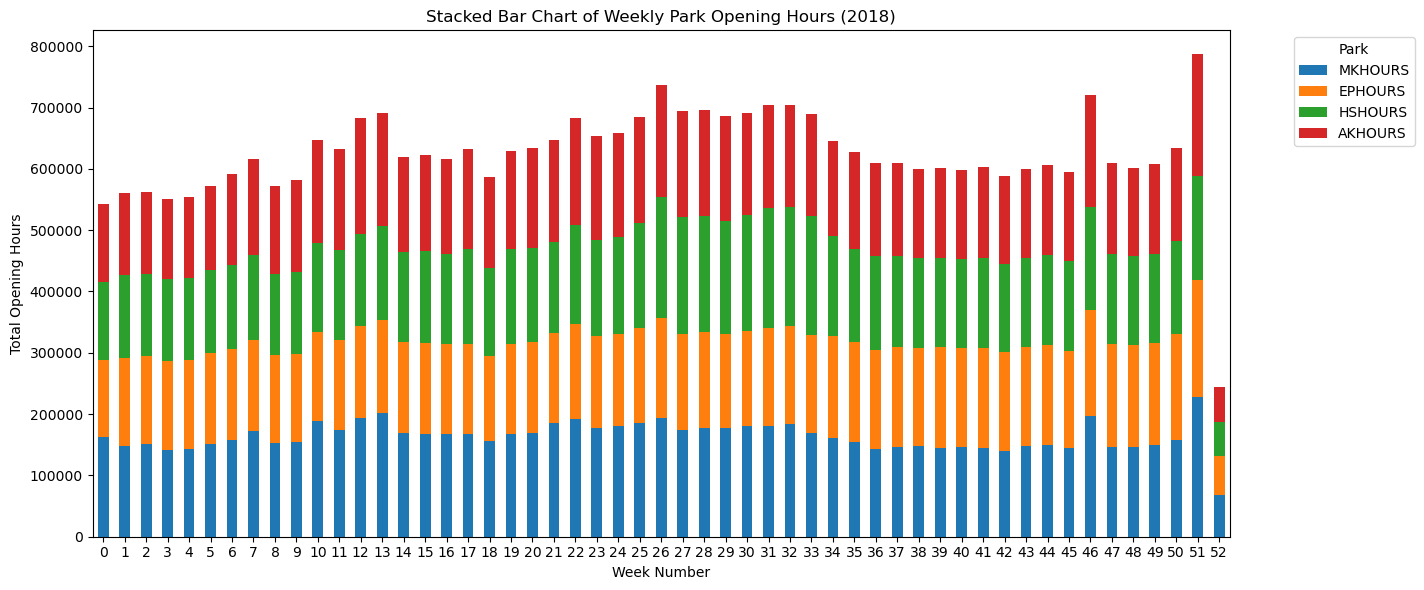

In [51]:
plt.figure(figsize=(16, 6))
sns.lineplot(data=weekly_hours.melt(id_vars='WEEKOFYEAR', var_name='park', value_name='total_hours'),
             x='WEEKOFYEAR', y='total_hours', hue='park', marker='o')
plt.title(f'Total Park Opening Hours per Week ({chosen_year})')
plt.xlabel('Week Number')
plt.ylabel('Total Opening Hours')
plt.grid(True, axis='y', alpha=0.5)
plt.legend(title='Park', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

plt.figure(figsize=(16, 6))
weekly_hours.set_index('WEEKOFYEAR').plot(kind='bar', stacked=True, figsize=(16, 6))
plt.title(f'Stacked Bar Chart of Weekly Park Opening Hours ({chosen_year})')
plt.xlabel('Week Number')
plt.ylabel('Total Opening Hours')
plt.xticks(rotation=0)
plt.legend(title='Park', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

Drop omdat week 52 bestaat uit 2 dagen.

In [52]:
chosen_year = 2018

df_opening_year = df_int_time_p_opening.copy()

df_opening_year['date'] = pd.to_datetime(df_opening_year['date'])
filtered_year = df_opening_year[df_opening_year['date'].dt.year == chosen_year].copy() 

desired_year_columns = ['date', 'DAYOFWEEK', 'DAYOFYEAR', 'WEEKOFYEAR', 'MONTHOFYEAR', 'YEAR', 'MKHOURS', 'EPHOURS', 'HSHOURS', 'AKHOURS']
opening_hours_per_park_year = filtered_year[desired_year_columns].drop_duplicates().copy()

# Filter for week 52
week_52_data = opening_hours_per_park_year[opening_hours_per_park_year['WEEKOFYEAR'] == 52]

# Display the result
display(week_52_data)

,date,DAYOFWEEK,DAYOFYEAR,WEEKOFYEAR,MONTHOFYEAR,YEAR,MKHOURS,EPHOURS,HSHOURS,AKHOURS
2370555,2018-12-30,1,363,52,12,2018,16.0,13.5,12.0,15.0
2372590,2018-12-31,2,364,52,12,2018,17.0,17.0,15.0,13.0


In [53]:
# age_influence = df_itp_entities.copy()



# age_influence = age_influence[['attraction', 'date', 'minute', 'SPOSTMIN', 'height_restriction', 'intense']].copy()
# display(age_influence.head())


In [54]:


# # 1. Height Restriction vs. SPOSTMIN (Violin Plot)
# plt.figure(figsize=(10, 6))
# sns.violinplot(x='height_restriction', y='SPOSTMIN', data=age_influence)
# plt.title('Influence of Height Restriction on Wait Times')
# plt.xlabel('Height Restriction')
# plt.ylabel('Wait Time (SPOSTMIN)')
# plt.ylim(-20, 350)
# plt.show()

# # 2. Intense vs. SPOSTMIN (Violin Plot)
# plt.figure(figsize=(6, 6))
# sns.violinplot(x='intense', y='SPOSTMIN', data=age_influence)
# plt.title('Influence of Intensity on Wait Times')
# plt.xlabel('Intense')
# plt.ylabel('Wait Time (SPOSTMIN)')
# plt.ylim(-20, 350)
# plt.show()

# # 3. Mean SPOSTMIN by Height Restriction
# plt.figure(figsize=(8, 6))
# sns.barplot(x='height_restriction', y='SPOSTMIN', data=age_influence, estimator='mean')
# plt.title('Mean Wait Time by Height Restriction')
# plt.xlabel('Height Restriction')
# plt.ylabel('Mean Wait Time (SPOSTMIN)')
# plt.ylim(0, 40)
# plt.show()

# # 4. Mean SPOSTMIN by Intensity
# plt.figure(figsize=(8, 6))
# sns.barplot(x='intense', y='SPOSTMIN', data=age_influence, estimator='mean')
# plt.title('Mean Wait Time by Intensity')
# plt.xlabel('Intensity')
# plt.ylabel('Mean Wait Time (SPOSTMIN)')
# plt.ylim(0, 25)
# plt.show()


In [55]:

# unique_rides = age_influence[['attraction', 'height_restriction', 'intense']].drop_duplicates()

# display(unique_rides)

# max_times_spos = age_influence.groupby('height_restriction')['SPOSTMIN'].max().reset_index()
# display(max_times_spos)


# max_times = age_influence_pred_2018.groupby('height_restriction')['predicted_actual_time'].max().reset_index()
# display(max_times)



In [56]:
# age_influence_pred = df_wt_pred_entities.copy()
# age_influence_pred = age_influence_pred[['attraction', 'date', 'minute','predicted_actual_time','height_restriction', 'intense']].copy()

# # Filter for the year 2018
# age_influence_pred['year'] = pd.to_datetime(age_influence_pred['date']).dt.year
# age_influence_pred_2018 = age_influence_pred[age_influence_pred['year'] == 2018].copy()

# display(age_influence_pred_2018)

# # 1. Height Restriction vs. SPOSTMIN (Violin Plot)
# plt.figure(figsize=(10, 6))
# sns.violinplot(x='height_restriction', y='predicted_actual_time', data=age_influence_pred_2018)
# plt.title('Influence of Height Restriction on Wait Times (2018)')
# plt.xlabel('Height Restriction')
# plt.ylabel('Wait Time')
# plt.ylim(-20, 350)
# plt.show()

# # 2. Intense vs. SPOSTMIN (Violin Plot)
# plt.figure(figsize=(6, 6))
# sns.violinplot(x='intense', y='predicted_actual_time', data=age_influence_pred_2018)
# plt.title('Influence of Intensity on Wait Times (2018)')
# plt.xlabel('Intense')
# plt.ylabel('Wait Time')
# plt.ylim(-20, 350)
# plt.show()

# # 3. Mean SPOSTMIN by Height Restriction
# plt.figure(figsize=(8, 6))
# sns.barplot(x='height_restriction', y='predicted_actual_time', data=age_influence_pred_2018, estimator='mean')
# plt.title('Mean Wait Time by Height Restriction (2018)')
# plt.xlabel('Height Restriction')
# plt.ylabel('Mean Wait Time')
# plt.ylim(0, 40)
# plt.show()

# # 4. Mean SPOSTMIN by Intensity
# plt.figure(figsize=(8, 6))
# sns.barplot(x='intense', y='predicted_actual_time', data=age_influence_pred_2018, estimator='mean')
# plt.title('Mean Wait Time by Intensity (2018)')
# plt.xlabel('Intensity')
# plt.ylabel('Mean Wait Time')
# plt.ylim(0, 25)
# plt.show()


In [57]:
# # Plot 1: age_influence
# plt.figure(figsize=(8, 6))
# sns.barplot(x='height_restriction', y='SPOSTMIN', data=age_influence, estimator='mean')
# plt.title('Mean Wait Time by Height Restriction')
# plt.xlabel('Height Restriction')
# plt.ylabel('Mean Wait Time (SPOSTMIN)')
# plt.ylim(0, 40)  # Set the y-axis limit to 40
# plt.show()

# # Plot 2: age_influence_pred_2018
# plt.figure(figsize=(8, 6))
# sns.barplot(x='height_restriction', y='predicted_actual_time', data=age_influence_pred_2018, estimator='mean')
# plt.title('Mean Wait Time by Height Restriction (2018)')
# plt.xlabel('Height Restriction')
# plt.ylabel('Mean Wait Time')
# plt.ylim(0, 40)  # Set the y-axis limit to 40
# plt.show()


,attraction,date,minute,SPOSTMIN,scope_and_scale_code
0,astro_orbiter,2015-01-01,0,0.0,minor_attraction
1,astro_orbiter,2015-01-01,30,0.0,minor_attraction
2,astro_orbiter,2015-01-01,60,0.0,minor_attraction
3,astro_orbiter,2015-01-01,90,0.0,minor_attraction
4,astro_orbiter,2015-01-01,120,0.0,minor_attraction


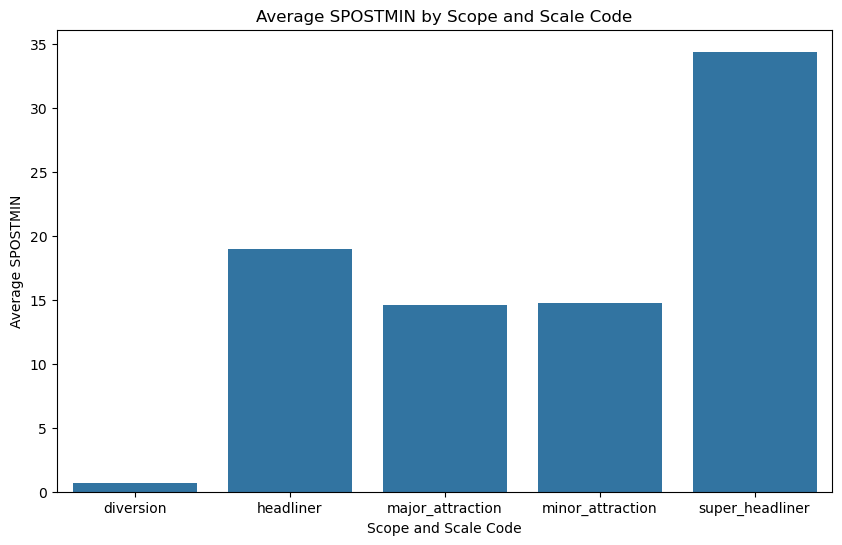

In [58]:
popularity_influence = df_itp_entities.copy()

popularity_influence = popularity_influence[['attraction', 'date', 'minute', 'SPOSTMIN', 'scope_and_scale_code']].copy()
display(popularity_influence.head())

# Calculate average SPOSTMIN by scope_and_scale_code
avg_spostmin_scope = popularity_influence.groupby('scope_and_scale_code')['SPOSTMIN'].mean().reset_index()

# Visualize average SPOSTMIN by scope_and_scale_code
plt.figure(figsize=(10, 6))
sns.barplot(x='scope_and_scale_code', y='SPOSTMIN', data=avg_spostmin_scope)
plt.title('Average SPOSTMIN by Scope and Scale Code')
plt.xlabel('Scope and Scale Code')
plt.ylabel('Average SPOSTMIN')
plt.show()


In [59]:
go_time_comparison = df_itp_entities.copy()

go_time_comparison = go_time_comparison[['attraction', 'date', 'minute', 'SPOSTMIN', 'when_to_go', 'probable_wait_time']].copy()
display(go_time_comparison.head())

unique_when_to_go = df_itp_entities['when_to_go'].unique()

print(unique_when_to_go)

chosen_date = '2018-07-15'  # Replace with your desired date

chosen_day_data = go_time_comparison[go_time_comparison['date'] == chosen_date]

display(chosen_day_data)

,attraction,date,minute,SPOSTMIN,when_to_go,probable_wait_time
0,astro_orbiter,2015-01-01,0,0.0,Before 11 a.m. or during the last hour before ...,0
1,astro_orbiter,2015-01-01,30,0.0,Before 11 a.m. or during the last hour before ...,0
2,astro_orbiter,2015-01-01,60,0.0,Before 11 a.m. or during the last hour before ...,0
3,astro_orbiter,2015-01-01,90,0.0,Before 11 a.m. or during the last hour before ...,0
4,astro_orbiter,2015-01-01,120,0.0,Before 11 a.m. or during the last hour before ...,0


['Before 11 a.m. or during the last hour before closing.'
 'Before 10:30 a.m., during parades, or in the evening just before the park closes.'
 'Before 10 a.m., in the hour before closing.'
 'First or last hour the park is open.' 'Before 11 a.m. or after 7 p.m.'
 'Before 11:30 a.m. or after 8 p.m.' 'Anytime'
 'Before 10 a.m. or 2 hours before closing.'
 'Before 11 a.m. or after 5 p.m.'
 'Before 10 a.m. or in the hour before park closing.'
 'First or last 30 minutes the park is open.'
 'Before 11 a.m., during parades, or use Lightning Lane'
 'Before noon or after 5 p.m.' 'When the park opens.'
 'Before 10 a.m. or during last 2 hours before closing.' '0'
 'Before 10:30 a.m., during the last 2 hours before closing.'
 'Before 10 a.m., in the 2 hours before closing.'
 'Before 11 a.m. or after 3:30 p.m.'
 'Before 11:30 a.m., before a parade, or during the two hours before closing'
 'Midmorning-late afternoon'
 'Anytime, but after dark is better for the effects'
 'Anytime, but especially duri

,attraction,date,minute,SPOSTMIN,when_to_go,probable_wait_time
1405965,astro_orbiter,2018-07-15,0,0.0,Before 11 a.m. or during the last hour before ...,0
1405966,astro_orbiter,2018-07-15,30,0.0,Before 11 a.m. or during the last hour before ...,0
1405967,astro_orbiter,2018-07-15,60,0.0,Before 11 a.m. or during the last hour before ...,0
1405968,astro_orbiter,2018-07-15,90,0.0,Before 11 a.m. or during the last hour before ...,0
1405969,astro_orbiter,2018-07-15,120,0.0,Before 11 a.m. or during the last hour before ...,0
...,...,...,...,...,...,...
1407005,winnie_the_pooh,2018-07-15,1500,5.0,"Before 10 a.m., in the 2 hours before closing.",0
1407006,winnie_the_pooh,2018-07-15,1530,5.0,"Before 10 a.m., in the 2 hours before closing.",0
1407007,winnie_the_pooh,2018-07-15,1560,5.0,"Before 10 a.m., in the 2 hours before closing.",0
1407008,winnie_the_pooh,2018-07-15,1590,5.0,"Before 10 a.m., in the 2 hours before closing.",0


In [60]:
df_day_opening = df_int_time_p_opening.copy()

# Convert 'date' to datetime if it's not already
df_day_opening['date'] = pd.to_datetime(df_day_opening['date'])

chosen_date = '2018-07-15'
# Filter based on chosen_month and chosen_year
day_df = df_day_opening[df_day_opening['date'].dt.day == chosen_date].copy()

# Explicitly define the columns you want
desired_columns = ['date', 'DAYOFWEEK', 'DAYOFYEAR', 'WEEKOFYEAR', 'MONTHOFYEAR', 'YEAR',
                          'MKOPEN', 'MKCLOSE', 'MKHOURS',
                          'EPOPEN', 'EPCLOSE', 'EPHOURS',
                          'HSOPEN', 'HSCLOSE', 'HSHOURS',
                          'AKOPEN', 'AKCLOSE', 'AKHOURS']

# Create a new DataFrame with only the desired columns
open_day = day_df[desired_columns].copy()

# Display the result
display(open_day)

,date,DAYOFWEEK,DAYOFYEAR,WEEKOFYEAR,MONTHOFYEAR,YEAR,MKOPEN,MKCLOSE,MKHOURS,EPOPEN,EPCLOSE,EPHOURS,HSOPEN,HSCLOSE,HSHOURS,AKOPEN,AKCLOSE,AKHOURS


In [61]:


col_names = list(chosen_day_data)

for col in col_names:
      unique_values = set(chosen_day_data[col].dropna().explode())
      print(f"'{col}': {unique_values}")

'attraction': {'town_sq_mickey', 'peter_pan_s_flight', 'space_mountain', 'astro_orbiter', 'it_s_a_small_world', 'barnstormer', 'pirates_of_caribbean', 'laugh_floor', 'under_the_sea', 'dumbo', 'tom_land_speedway', 'mad_tea_party', 'buzz_lightyear', 'haunted_mansion', 'magic_carpets', 'big_thunder_mtn', 'jungle_cruise', 'philharmagic', 'winnie_the_pooh'}
'date': {Timestamp('2018-07-15 00:00:00')}
'minute': {0, 1410, 900, 390, 1290, 780, 270, 1170, 660, 150, 1560, 1050, 540, 30, 1440, 930, 420, 1320, 810, 300, 1200, 690, 180, 1590, 1080, 570, 60, 1470, 960, 450, 1350, 840, 330, 1230, 720, 210, 1620, 1110, 600, 90, 1500, 990, 480, 1380, 870, 360, 1260, 750, 240, 1140, 630, 120, 1530, 1020, 510}
'SPOSTMIN': {0.0, 65.0, 35.0, 5.0, 70.0, 40.0, 10.0, 75.0, 45.0, 15.0, 80.0, 50.0, 20.0, 85.0, 55.0, 25.0, 60.0, 30.0}
'when_to_go': {'Before 10 a.m. or 2 hours before closing.', 'Before 11 a.m., during parades, or use Lightning Lane', 'Before 11 a.m. or after 7 p.m.', 'Before 10 a.m., in the hour b